**ПРОГНОЗИРОВАНИЕ ОТТОКА КЛИЕНТОВ ОПЕРАТОРА СВЯЗИ**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**ЦЕЛЬ ПРОЕКТА**

Перед нами задача бинарной классифкации. Цель - создание модели для прогнозирования оттока клиентов и достижение минимального порога AUC-ROC=0.85

**ОПИСАНИЕ УСЛУГ**<br><br>
Оператор предоставляет два основных типа услуг: <br><br> 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).<br><br>
Также доступны такие услуги:<br><br> - Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);<br> - Выделенная линия технической поддержки (TechSupport);
Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**ОПИСАНИЕ ДАННЫХ**<br><br>
Данные состоят из файлов, полученных из разных источников:<br><br>
**contract_new.csv** — информация о договоре;<br>
**personal_new.csv** — персональные данные клиента;<br>
**internet_new.csv** — информация об интернет-услугах;<br>
**phone_new.csv** — информация об услугах телефонии.<br><br>
Во всех файлах столбец customerID содержит код клиента.<br>
Информация о договорах актуальна на 1 февраля 2020.

**ПЛАН ВЫПОЛНЕНИЯ**

1.Загрузка и открытие файлов с данными.<br> - Изучение общей информации<br>- Предобработка данных<br>- Поиск и преобразование целевого признака<br>- Объединить необходимые данные в одну таблицу.<br>2.Предобработка и исследовательский анализ данных.<br> - Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.<br>- Провести исследоавательский анализ данных с визуализацией<br>- Выявить зависимость целевого признака от остальных признаков.<br>3. Подготовить выборки для обучения моделей.<br>4. Обучить разные модели.<br>5. Проанализировать время обучения и качество моделей.<br>6. Выбрать лучшую модель, проверить её качество на тестовой выборке. Убедится, что достигнуто необходимое значение метрики.<br>7. Вывод. Отчет.

## Загрузка и открытие файлов с данными

In [1]:
! pip install phik

     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01


In [2]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 47 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [3]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


### Импорт библиотек

In [4]:
# частично импортируем библиотеки, добавлять будем по мере выполнения проекта

import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.compose import make_column_transformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve

warnings.filterwarnings("ignore")

sns.set_palette('Set3')

# константы 
RANDOM_STATE = 140823

### Загрузка данных, общая информация, предобработка

In [5]:
# Загрузка файлов с данными:
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contract = pd.read_csv('contract_new.csv')
    internet = pd.read_csv('internet_new.csv')
    personal = pd.read_csv('personal_new.csv')
    phone = pd.read_csv('phone_new.csv')

In [6]:
# создаем функцию для просмотра общей информации о данных

def dataset(data):
    print()
    print('Общая информация')
    print()
    print(data.info())
    print()
    print('Размер данных:', data.shape, 'Кoличество ячееек:', data.size)
    print()
    print('Первые 5 строк')
    display(data.head())
    print()
    print('Выборочно 10 строк')
    display(data.sample(10))
    print()
    print('Количество пропусков:')
    display(data.isna().sum())
    print()
    print('Количество дубликатов')
    display(data.duplicated().sum())
    print()
    print('Список столбцов')
    print(data.columns)
    print()
    print('Приводим названия столбцов к нижнему регистру')
    data.columns = data.columns.str.lower()
    print(data.columns)

In [7]:
# приводим все строчные объекты к нижнему регистру, убираем пробелы в начале и в конце строки
# заменяем пробелы внутри строки на нижнее подчеркивание

def dataset2(data):
    
    print()
    print('Cписок столбцов с типом object')
    data_object = data.select_dtypes(include=object).columns
    print(data_object)
    for i in data_object:
        data[i] = data[i].str.lower().str.strip().str.replace(' ', '_', regex=True)
    print()
    
    # повторная проверка наличия пропусков и дубликатов
    print()
    print("Размер данных", data.shape)
    print()
    print('Повторная проверка количества пропусков:')
    display(data.isna().sum())
    print()
    print('Повторная проверка наличия явных дубликатов')
    display(data.duplicated().sum())
    print()
    display(data.sample(10))

In [8]:
def dataset3(data):
    print()
    print('Общая информация')
    print()
    print(data.info())
    print()
    print('Размер данных:', data.shape, 'Кoличество ячееек:', data.size)
    print()
    print('Первые 5 строк')
    display(data.head())
    print()
    print('Выборочно 10 строк')
    display(data.sample(10))
    print()
    print('Количество пропусков:')
    display(data.isna().sum())
    print()
    print('Количество дубликатов')
    display(data.duplicated().sum())
    print()
    print('Список столбцов')
    print(data.columns)
    print()
    display(data.describe())

#### Файл contract "Информация о договоре"

In [11]:
# Информация по contract (contract_new.csv)

dataset(contract)


Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Размер данных: (7043, 8) Кoличество ячееек: 56344

Первые 5 строк


customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5


Выборочно 10 строк


customerID   BeginDate     EndDate            Type PaperlessBilling  \
948   7028-DVOIQ  2017-02-01          No  Month-to-month              Yes   
248   0322-YINQP  2019-09-01          No  Month-to-month              Yes   
3432  8174-TBVCF  2014-04-01          No        Two year              Yes   
84    0318-ZOPWS  2016-01-01          No        Two year              Yes   
5323  1448-CYWKC  2015-04-01          No        One year              Yes   
3534  2165-VOEGB  2016-02-01          No        One year              Yes   
4897  2533-TIBIX  2018-11-01          No  Month-to-month              Yes   
6374  1293-BSEUN  2014-02-01  2015-07-01        Two year              Yes   
6566  3795-CAWEX  2014-04-01          No        Two year              Yes   
6068  3945-GFWQL  2018-11-01          No  Month-to-month              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
948            Electronic check           99.05      3672.77  
248                Mailed check           48.55       242.75  
3432    Credit card (automatic)           94.80       6636.0  
84    Bank transfer (automatic)           20.15       987.35  
5323    Credit card (automatic)          105.20      6345.66  
3534  Bank transfer (automatic)          105.20      5251.58  
4897  Bank transfer (automatic)           30.20        453.0  
6374               Mailed check           20.70       373.01  
6566    Credit card (automatic)          116.55       8158.5  
6068           Electronic check           44.55       708.35


Количество пропусков:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


Количество дубликатов


0


Список столбцов
Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

Приводим названия столбцов к нижнему регистру
Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')


**Итого** по contract "Информация о договоре":<br><br> 
Таблица состоит из 7043 строк с индексом от 0 до 7042 (размер данных: (7043, 8), кoличество ячееек: 56344.<br> Т.о. имеем 7043 уникальных пользователя.<br>
Столбцы:<br> 
- customerID - идентификатор клиента, тип object;<br> 
- BeginDate - дата начала пользования услугами, дата заключения договора, тип object;<br>
- EndDate - дата окончания договора, тип object;<br>
- Type - тип оплаты: ежемесячный, годовой и т.д., тип object;<br>
- PaperlessBilling - электронный платежный документ, тип object;<br>
- PaymentMethod - способ оплаты, тип object;<br>
- MonthlyCharges - ежемесячные траты на услуги, ежемесячные платежи, тип float64;<br>
- TotalCharges - всего потрачено денег на услуги, всего начислений, тип object;<br><br>
Признаки числовые и категориальные. Если признаки важны, у некоторых требуется поменять тип данных. <br><br>
Пропуски отсутствуют, явные дубликаты отсутствуют.<br><br> Данные с типом object привели к нижнему регистру, удалили пробелы в начале и в конце строки, пробелы внутри строки заменили на нижнее подчеркивание.<br><br>
В названии столбцов небходимо поменять регистр.<br>
В столбце BeginDate сменить тип на datetime. В столбце TotalCharges сменить тип на float. <br><br>


In [12]:
# откорректируем названия столбцов

contract.rename(columns = {'customerid': 'customer_id', 
                           'begindate': 'begin_date', 
                           'enddate': 'end_date_original', 
                           'paperlessbilling': 'paper_less_billing',
                           'paymentmethod': 'payment_method', 
                           'monthlycharges': 'monthly_charges', 
                           'totalcharges': 'total_charges'}, inplace = True )
print(contract.columns)

Index(['customer_id', 'begin_date', 'end_date_original', 'type',
       'paper_less_billing', 'payment_method', 'monthly_charges',
       'total_charges'],
      dtype='object')


In [13]:
# преобразуем тип данных contract['begin_date'] в datetime

contract['begin_date'] = pd.to_datetime(contract['begin_date'])
print(contract['begin_date'].dtype)

datetime64[ns]


При попытке смены типа данных в contract['total_charges'] к типу float возникла ошибка, так как обнаружились значения " " (пусто).

In [14]:
# уникальные значения столбца contract['total_charges'] по убыванию

contract['total_charges'].unique()

array(['31.04', '2071.84', '226.17', ..., '325.6', '520.8', '7251.82'],
      dtype=object)

In [15]:
# выведем строки с пустым значением

print(len(contract.loc[contract['total_charges'] == ' ']))

display(contract.loc[contract['total_charges'] == ' '])

11


customer_id begin_date end_date_original      type paper_less_billing  \
488   4472-LVYGI 2020-02-01                No  Two year                Yes   
753   3115-CZMZD 2020-02-01                No  Two year                 No   
936   5709-LVOEQ 2020-02-01                No  Two year                 No   
1082  4367-NUYAO 2020-02-01                No  Two year                 No   
1340  1371-DWPAZ 2020-02-01                No  Two year                 No   
3331  7644-OMVMY 2020-02-01                No  Two year                 No   
3826  3213-VVOLG 2020-02-01                No  Two year                 No   
4380  2520-SGTTA 2020-02-01                No  Two year                 No   
5218  2923-ARZLG 2020-02-01                No  One year                Yes   
6670  4075-WKNIU 2020-02-01                No  Two year                 No   
6754  2775-SEFEE 2020-02-01                No  Two year                Yes   

                 payment_method  monthly_charges total_charges  
488   Bank transfer (automatic)            52.55                
753                Mailed check            20.25                
936                Mailed check            80.85                
1082               Mailed check            25.75                
1340    Credit card (automatic)            56.05                
3331               Mailed check            19.85                
3826               Mailed check            25.35                
4380               Mailed check            20.00                
5218               Mailed check            19.70                
6670               Mailed check            73.35                
6754  Bank transfer (automatic)            61.90

Всего 11 строк с пропущенным значением, датированы 01 февраля 2020 года (момент выгрузки данных), договора действующие, следовательно можно предположить, что общая сумма еще не сформирована, т.к. клиент пользовался услугами 1 день. Вероятно, можно заполнить эти пропуски значением столбца monthly_charges, либо 0. Заполним значением столбца monthly_charges.

In [16]:
display(contract.loc[contract['begin_date'] == '2020-02-01'])
print(len(contract.loc[contract['begin_date'] == '2020-02-01']))

customer_id begin_date end_date_original      type paper_less_billing  \
488   4472-LVYGI 2020-02-01                No  Two year                Yes   
753   3115-CZMZD 2020-02-01                No  Two year                 No   
936   5709-LVOEQ 2020-02-01                No  Two year                 No   
1082  4367-NUYAO 2020-02-01                No  Two year                 No   
1340  1371-DWPAZ 2020-02-01                No  Two year                 No   
3331  7644-OMVMY 2020-02-01                No  Two year                 No   
3826  3213-VVOLG 2020-02-01                No  Two year                 No   
4380  2520-SGTTA 2020-02-01                No  Two year                 No   
5218  2923-ARZLG 2020-02-01                No  One year                Yes   
6670  4075-WKNIU 2020-02-01                No  Two year                 No   
6754  2775-SEFEE 2020-02-01                No  Two year                Yes   

                 payment_method  monthly_charges total_charges  
488   Bank transfer (automatic)            52.55                
753                Mailed check            20.25                
936                Mailed check            80.85                
1082               Mailed check            25.75                
1340    Credit card (automatic)            56.05                
3331               Mailed check            19.85                
3826               Mailed check            25.35                
4380               Mailed check            20.00                
5218               Mailed check            19.70                
6670               Mailed check            73.35                
6754  Bank transfer (automatic)            61.90

11


In [17]:
contract['total_charges'] = contract['total_charges'].replace(' ', np.nan)

In [18]:
# выведем строки с пустым значением

print(len(contract.loc[contract['total_charges'] == ' ']))

display(contract.loc[contract['total_charges'] == ' '])

print()
display(contract.loc[contract['total_charges'].isna()])

# количество пропущенных значений
print(contract['total_charges'].isna().sum())

0


Empty DataFrame
Columns: [customer_id, begin_date, end_date_original, type, paper_less_billing, payment_method, monthly_charges, total_charges]
Index: []

customer_id begin_date end_date_original      type paper_less_billing  \
488   4472-LVYGI 2020-02-01                No  Two year                Yes   
753   3115-CZMZD 2020-02-01                No  Two year                 No   
936   5709-LVOEQ 2020-02-01                No  Two year                 No   
1082  4367-NUYAO 2020-02-01                No  Two year                 No   
1340  1371-DWPAZ 2020-02-01                No  Two year                 No   
3331  7644-OMVMY 2020-02-01                No  Two year                 No   
3826  3213-VVOLG 2020-02-01                No  Two year                 No   
4380  2520-SGTTA 2020-02-01                No  Two year                 No   
5218  2923-ARZLG 2020-02-01                No  One year                Yes   
6670  4075-WKNIU 2020-02-01                No  Two year                 No   
6754  2775-SEFEE 2020-02-01                No  Two year                Yes   

                 payment_method  monthly_charges total_charges  
488   Bank transfer (automatic)            52.55           NaN  
753                Mailed check            20.25           NaN  
936                Mailed check            80.85           NaN  
1082               Mailed check            25.75           NaN  
1340    Credit card (automatic)            56.05           NaN  
3331               Mailed check            19.85           NaN  
3826               Mailed check            25.35           NaN  
4380               Mailed check            20.00           NaN  
5218               Mailed check            19.70           NaN  
6670               Mailed check            73.35           NaN  
6754  Bank transfer (automatic)            61.90           NaN

11


In [19]:
# теперь можно заменить тип данных на float и заполнить пропуски

contract['total_charges'] = contract['total_charges'].astype(float)
print(contract['total_charges'].dtype)

float64


In [20]:
contract.loc[contract['total_charges'].isna() & (contract['monthly_charges']), 'total_charges'] = contract['monthly_charges']

In [21]:
display(contract.loc[contract['begin_date'] == '2020-02-01'])
print(len(contract.loc[contract['begin_date'] == '2020-02-01']))

customer_id begin_date end_date_original      type paper_less_billing  \
488   4472-LVYGI 2020-02-01                No  Two year                Yes   
753   3115-CZMZD 2020-02-01                No  Two year                 No   
936   5709-LVOEQ 2020-02-01                No  Two year                 No   
1082  4367-NUYAO 2020-02-01                No  Two year                 No   
1340  1371-DWPAZ 2020-02-01                No  Two year                 No   
3331  7644-OMVMY 2020-02-01                No  Two year                 No   
3826  3213-VVOLG 2020-02-01                No  Two year                 No   
4380  2520-SGTTA 2020-02-01                No  Two year                 No   
5218  2923-ARZLG 2020-02-01                No  One year                Yes   
6670  4075-WKNIU 2020-02-01                No  Two year                 No   
6754  2775-SEFEE 2020-02-01                No  Two year                Yes   

                 payment_method  monthly_charges  total_charges  
488   Bank transfer (automatic)            52.55          52.55  
753                Mailed check            20.25          20.25  
936                Mailed check            80.85          80.85  
1082               Mailed check            25.75          25.75  
1340    Credit card (automatic)            56.05          56.05  
3331               Mailed check            19.85          19.85  
3826               Mailed check            25.35          25.35  
4380               Mailed check            20.00          20.00  
5218               Mailed check            19.70          19.70  
6670               Mailed check            73.35          73.35  
6754  Bank transfer (automatic)            61.90          61.90

11


Столбец **EndDate** - будет **целевым** признаком, так как именно расторжение (прекращение) договора является признаком оотока клиента. Необходимо заменить данные столбца на "0" (если договор действующий) и на "1" (если договор расторгнут). Пока не ясно, нужна ли дата расторжения договора, поэтому столбец 'enddate' перезапишем как 'end_date_original' и добавим новый столбец с целочисленным значением "0" или "1" в зависимости от статуса договора.

In [22]:
# добавим новый столбец с целочисленным значением "0" или "1" в зависимости от статуса договора.

def categorize(row):
    if row  == 'No':
        return '0'
    return '1'

In [23]:
contract['end_date'] = contract['end_date_original'].apply(categorize)
contract['end_date'] = contract['end_date'].astype(int)
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         7043 non-null   object        
 1   begin_date          7043 non-null   datetime64[ns]
 2   end_date_original   7043 non-null   object        
 3   type                7043 non-null   object        
 4   paper_less_billing  7043 non-null   object        
 5   payment_method      7043 non-null   object        
 6   monthly_charges     7043 non-null   float64       
 7   total_charges       7043 non-null   float64       
 8   end_date            7043 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 495.3+ KB


In [24]:
contract.head()

customer_id begin_date end_date_original            type paper_less_billing  \
0  7590-VHVEG 2020-01-01                No  Month-to-month                Yes   
1  5575-GNVDE 2017-04-01                No        One year                 No   
2  3668-QPYBK 2019-10-01                No  Month-to-month                Yes   
3  7795-CFOCW 2016-05-01                No        One year                 No   
4  9237-HQITU 2019-09-01                No  Month-to-month                Yes   

              payment_method  monthly_charges  total_charges  end_date  
0           Electronic check            29.85          31.04         0  
1               Mailed check            56.95        2071.84         0  
2               Mailed check            53.85         226.17         0  
3  Bank transfer (automatic)            42.30        1960.60         0  
4           Electronic check            70.70         353.50         0

In [25]:
contract['end_date'].unique()

array([0, 1])

In [26]:
# проверки данных после обработки

dataset2(contract)


Cписок столбцов с типом object
Index(['customer_id', 'end_date_original', 'type', 'paper_less_billing',
       'payment_method'],
      dtype='object')


Размер данных (7043, 9)

Повторная проверка количества пропусков:


customer_id           0
begin_date            0
end_date_original     0
type                  0
paper_less_billing    0
payment_method        0
monthly_charges       0
total_charges         0
end_date              0
dtype: int64


Повторная проверка наличия явных дубликатов


0

customer_id begin_date end_date_original            type  \
5909  5343-sgubi 2015-10-01        2017-07-01        one_year   
2840  7299-gnvpl 2018-03-01                no  month-to-month   
1362  2568-brgyx 2019-07-01                no  month-to-month   
3419  1063-dhqjf 2014-05-01                no        two_year   
1557  4672-fotsd 2019-02-01                no  month-to-month   
2213  5197-ypybz 2019-02-01                no        two_year   
3535  3612-yungg 2014-10-01        2016-07-01        two_year   
702   1766-gknmi 2017-09-01                no  month-to-month   
4293  2114-mgina 2018-09-01                no  month-to-month   
764   7969-ffowg 2014-09-01                no        two_year   

     paper_less_billing           payment_method  monthly_charges  \
5909                yes             mailed_check            80.20   
2840                 no             mailed_check            84.40   
1362                yes         electronic_check            70.20   
3419                yes             mailed_check            92.15   
1557                yes         electronic_check            67.25   
2213                 no  credit_card_(automatic)            25.25   
3535                yes  credit_card_(automatic)           109.20   
702                 yes         electronic_check            84.90   
4293                yes             mailed_check            89.80   
764                  no             mailed_check            19.90   

      total_charges  end_date  
5909        1751.57         1  
2840        1941.20         0  
1362         515.97         0  
3419        6358.35         0  
1557         887.70         0  
2213         306.03         0  
3535        2339.06         1  
702         2462.10         0  
4293        1526.60         0  
764         1293.50         0

In [27]:
# уникальные значения столбца "Дата заключения контракта"

print(contract['begin_date'].unique())
print('Минимальное значение contract["begin_date"]', contract['begin_date'].min())
print('Максимальное значение contract["begin_date"]', contract['begin_date'].max())

['2020-01-01T00:00:00.000000000' '2017-04-01T00:00:00.000000000'
 '2019-10-01T00:00:00.000000000' '2016-05-01T00:00:00.000000000'
 '2019-09-01T00:00:00.000000000' '2019-03-01T00:00:00.000000000'
 '2018-04-01T00:00:00.000000000' '2019-04-01T00:00:00.000000000'
 '2017-07-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2019-01-01T00:00:00.000000000' '2018-10-01T00:00:00.000000000'
 '2015-04-01T00:00:00.000000000' '2015-09-01T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000' '2014-05-01T00:00:00.000000000'
 '2015-10-01T00:00:00.000000000' '2014-03-01T00:00:00.000000000'
 '2018-05-01T00:00:00.000000000' '2019-11-01T00:00:00.000000000'
 '2019-02-01T00:00:00.000000000' '2016-01-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2014-02-01T00:00:00.000000000' '2018-06-01T00:00:00.000000000'
 '2019-12-01T00:00:00.000000000' '2017-11-01T00:00:00.000000000'
 '2019-06-01T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2017-02-01T00:00:00.000

Дата заключения договора охватывает период с 01 октября 2013 по 01 февраля 2020 (дата выгрузки данных)

In [28]:
# уникальные значения столбца "Дата расторжения контракта"

print(contract['end_date_original'].unique())
print('Минимальное значение contract["end_date_original"]', contract['end_date_original'].min())
print('Максимальное значение contract["end_date_original"]', contract['end_date_original'].max())

['no' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01' '2017-01-01'
 '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01' '2014-12-01'
 '2014-11-01']
Минимальное значение contract["end_date_original"] 2014-06-01
Максимальное значение contract["end_date_original"] no


Значение "no" заменим датой 01 февраля 2020 (дата выгрузки данных) и приведем столбец к типу datetime. Для моделей столбцы с датой не понадобятся, мы создадим в дальнейшем признак "количество дней контакта

In [29]:
contract['end_date_original'] = contract['end_date_original'].replace('no', '2020-02-01')
contract['end_date_original'] = pd.to_datetime(contract['end_date_original'])

In [30]:
# проверяем уникальные значения столбца "Дата расторжения контракта"

print(contract['end_date_original'].unique())
print('Минимальное значение contract["end_date_original"]', contract['end_date_original'].min())
print('Максимальное значение contract["end_date_original"]', contract['end_date_original'].max())
print()
print(contract['end_date_original'].dtype)

['2020-02-01T00:00:00.000000000' '2017-05-01T00:00:00.000000000'
 '2016-03-01T00:00:00.000000000' '2018-09-01T00:00:00.000000000'
 '2018-11-01T00:00:00.000000000' '2018-12-01T00:00:00.000000000'
 '2019-08-01T00:00:00.000000000' '2018-07-01T00:00:00.000000000'
 '2017-09-01T00:00:00.000000000' '2015-09-01T00:00:00.000000000'
 '2016-07-01T00:00:00.000000000' '2016-06-01T00:00:00.000000000'
 '2018-03-01T00:00:00.000000000' '2019-02-01T00:00:00.000000000'
 '2018-06-01T00:00:00.000000000' '2019-06-01T00:00:00.000000000'
 '2020-01-01T00:00:00.000000000' '2019-11-01T00:00:00.000000000'
 '2016-09-01T00:00:00.000000000' '2015-06-01T00:00:00.000000000'
 '2016-12-01T00:00:00.000000000' '2019-05-01T00:00:00.000000000'
 '2019-04-01T00:00:00.000000000' '2017-06-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000' '2018-04-01T00:00:00.000000000'
 '2018-08-01T00:00:00.000000000' '2018-02-01T00:00:00.000000000'
 '2019-07-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2014-06-01T00:00:00.000

In [31]:
# уникальные значения столбца "Тип оплаты"

print(contract['type'].unique())
print('Заменим "-" на нижнее подчеркивание')
contract['type'] = contract['type'].str.replace('-', '_', regex=True)
print(contract['type'].unique())

['month-to-month' 'one_year' 'two_year']
Заменим "-" на нижнее подчеркивание
['month_to_month' 'one_year' 'two_year']


In [32]:
# уникальные значения столбца "Электронный платежный документ"

print(contract['paper_less_billing'].unique())

['yes' 'no']


In [33]:
# уникальные значения столбца "Способ оплаты"

print(contract['payment_method'].unique())

['electronic_check' 'mailed_check' 'bank_transfer_(automatic)'
 'credit_card_(automatic)']


In [34]:
# статистика столбца "Ежемесячные траты на услуги"

print(contract['monthly_charges'].describe())

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64


In [35]:
# статистика столбца "Ежемесячные траты на услуги"

print(contract['total_charges'].describe())

count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64


In [36]:
# уникальные значения целевого признака - столбца "end_date"

print(contract['end_date'].unique())

[0 1]


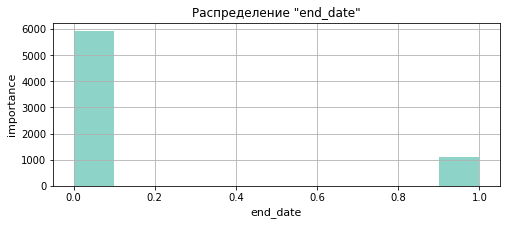

In [37]:
# Гистограмма целевого признака
contract['end_date'].hist(figsize=(8, 3))
plt.title(f'Распределение "end_date"', fontsize=12)
plt.xlabel('end_date', fontsize=11)
plt.ylabel('importance', fontsize=11)
plt.show()

In [38]:
# количество по классам 
print(contract['end_date'].value_counts())
print(len((contract['end_date'])))

0    5942
1    1101
Name: end_date, dtype: int64
7043


In [39]:
len(contract[contract['end_date'] == 0]) / len((contract['end_date']))

0.8436745704955275

In [40]:
len(contract[contract['end_date'] == 1]) / len((contract['end_date']))

0.15632542950447254

In [41]:
# % клиентов, которые ушли

contract['end_date'].mean()

0.15632542950447254

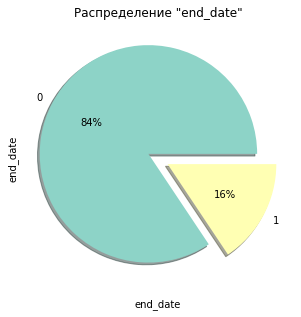

In [42]:
contract['end_date'].value_counts().plot(kind = 'pie', subplots=True,  figsize=(15, 5), 
                                         autopct='%1.0f%%', explode=[0.1, 0.1], shadow=True)
plt.rcParams['font.size'] = '15'
plt.title(f'Распределение "end_date"', fontsize=12)
plt.xlabel(('end_date'))
plt.show()

Присутствует дисбаланс. Количество действующих контрактов 84%, количество расторгнутых контрактов 16%.

Создадим новый столбец "contract_duration_days" - длительность контракта в днях

In [43]:
contract['contract_duration_days'] = (contract['end_date_original'] - contract['begin_date']).dt.days
display(contract['contract_duration_days'])

0         31
1       1036
2        123
3       1371
4        153
        ... 
7038     730
7039    2191
7040     337
7041     215
7042    2010
Name: contract_duration_days, Length: 7043, dtype: int64

In [44]:
# удаляем столбцы с датой

contract = contract.drop(['begin_date', 'end_date_original'], axis=1)

In [45]:
# проверяем итоговый DF contract
display(contract.sample(10))
print(contract.shape)
print(contract.info())

customer_id            type paper_less_billing  \
5463  6142-vsjqo  month_to_month                yes   
3735  3489-hhpfy  month_to_month                yes   
178   5947-sgkcl  month_to_month                yes   
6711  3545-cnwrg  month_to_month                yes   
1560  7338-eriva        one_year                 no   
5260  2495-kznfb  month_to_month                yes   
5407  9786-ywnhu        two_year                 no   
2477  1212-glhmd  month_to_month                yes   
1019  9391-ttoyh  month_to_month                yes   
4877  4973-rlzvi        one_year                 no   

                 payment_method  monthly_charges  total_charges  end_date  \
5463  bank_transfer_(automatic)            44.35         133.05         0   
3735           electronic_check            84.05         178.19         0   
178   bank_transfer_(automatic)           105.35        1738.28         0   
6711           electronic_check            98.35        4720.80         1   
1560  bank_transfer_(automatic)            45.05        1827.23         0   
5260           electronic_check            90.65        2991.45         0   
5407               mailed_check            63.55        4003.65         0   
2477               mailed_check            86.05         263.31         0   
1019               mailed_check            19.50         493.35         0   
4877    credit_card_(automatic)            74.65        2239.50         0   

      contract_duration_days  
5463                      92  
3735                      62  
178                      457  
6711                    1461  
1560                    1187  
5260                    1006  
5407                    1918  
2477                      92  
1019                     702  
4877                     914

(7043, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             7043 non-null   object 
 1   type                    7043 non-null   object 
 2   paper_less_billing      7043 non-null   object 
 3   payment_method          7043 non-null   object 
 4   monthly_charges         7043 non-null   float64
 5   total_charges           7043 non-null   float64
 6   end_date                7043 non-null   int64  
 7   contract_duration_days  7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB
None


#### Файл personal "Персональные данные клиента"

In [46]:
# Информация по personal (personal_new.csv)

dataset(personal)


Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Размер данных: (7043, 5) Кoличество ячееек: 35215

Первые 5 строк


customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No


Выборочно 10 строк


customerID  gender  SeniorCitizen Partner Dependents
2685  5781-BKHOP  Female              0     Yes         No
5126  4188-FRABG    Male              0     Yes         No
1634  9995-HOTOH    Male              0     Yes        Yes
1594  6485-QXWWE  Female              0      No        Yes
1733  1015-OWJKI    Male              0      No         No
51    9420-LOJKX  Female              0      No         No
3961  7421-ZLUPA  Female              0      No         No
4419  1045-LTCYT  Female              0     Yes        Yes
327   5804-LEPIM  Female              1      No         No
4438  2263-SFSQZ    Male              0     Yes        Yes


Количество пропусков:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


Количество дубликатов


0


Список столбцов
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

Приводим названия столбцов к нижнему регистру
Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents'], dtype='object')


**Итого** по personal "Персональные данные клиента":<br><br> 
Таблица состоит из 7043 строк с индексом от 0 до 7042 (размер данных: (7043, 5), кoличество ячееек: 35215.<br> Т.о. имеем 7043 уникальных пользователя. Количество уникальных пользователей совпадает с количеством пользователей в данных contract<br><br>
Столбцы:<br> 
- customerID - идентификатор клиента, тип object;<br> 
- gender - пол: мужины, женщины, тип object;<br>
- SeniorCitizen - наличие пенсионного статуса по возрасту, тип int (целочисленный);<br>
- Partner - наличие супруга(и), тип object;<br>
- Dependents - наличие иждивенцев, тип object;<br><br>

Все признаки категориальные.<br><br>
Пропуски отсутствуют, явные дубликаты отсутствуют.<br><br>

In [47]:
# откорректируем названия столбцов

personal.rename(columns = {'customerid': 'customer_id', 
                           'seniorcitizen': 'senior_citizen'}, 
                           inplace = True)
print(personal.columns)

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


In [48]:
dataset2(personal)


Cписок столбцов с типом object
Index(['customer_id', 'gender', 'partner', 'dependents'], dtype='object')


Размер данных (7043, 5)

Повторная проверка количества пропусков:


customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64


Повторная проверка наличия явных дубликатов


0

customer_id  gender  senior_citizen partner dependents
2980  5598-ikhqq  female               0      no         no
5078  9402-roumj  female               0     yes        yes
6074  3797-vtidr    male               0     yes         no
1088  7029-rpuav    male               1     yes         no
3086  3853-lygam    male               0      no         no
281   8229-myejz  female               0      no         no
2792  9163-ghaye  female               0      no         no
2684  5440-vhlul    male               0      no         no
2022  5989-pgkjb  female               0      no         no
5977  0780-xnzfn    male               0      no         no

In [49]:
# уникальные значения столбца "Пол"

print(personal['gender'].unique())

['female' 'male']


In [50]:
# уникальные значения столбца "Наличие супруга(и)"

print(personal['senior_citizen'].unique())
personal['senior_citizen'] = personal['senior_citizen'].astype(object)
print(personal['senior_citizen'].dtype)

[0 1]
object


In [51]:
# уникальные значения столбца "Наличие пенсионного статуса по возрасту"

print(personal['partner'].unique())

['yes' 'no']


In [52]:
# уникальные значения столбца "Наличие иждивенцев"

print(personal['dependents'].unique())

['no' 'yes']


In [53]:
# проверяем итоговый DF contract
display(personal.sample(10))
print(personal.shape)
print(personal.info())

customer_id  gender senior_citizen partner dependents
2582  7145-fejwu  female              0      no        yes
4485  7975-jmznt    male              0     yes         no
1513  0661-xeyan  female              1      no         no
6860  0402-cqajn  female              0      no         no
5125  2982-vpsgi  female              0     yes         no
707   8329-utmvm    male              1      no         no
827   9146-jriox  female              0     yes        yes
6230  9962-bfpdu  female              0     yes        yes
4779  0480-bixde  female              0     yes         no
2197  8548-awofc    male              0     yes         no

(7043, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
None


#### Файл internet " Информация об интернет услугах"

In [54]:
# Информация по internet (internet_new.csv)

dataset(internet)


Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Размер данных: (5517, 8) Кoличество ячееек: 44136

Первые 5 строк


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No


Выборочно 10 строк


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
5279  9003-CPATH     Fiber optic             No           No              Yes   
3852  5566-SOEZD     Fiber optic            Yes          Yes               No   
1161  6234-PFPXL     Fiber optic            Yes           No               No   
2649  5578-NKCXI     Fiber optic            Yes          Yes               No   
1309  3049-NDXFL     Fiber optic             No           No               No   
2484  1814-WFGVS             DSL            Yes           No              Yes   
717   7997-EASSD     Fiber optic             No           No               No   
4492  2398-YPMUR     Fiber optic             No           No               No   
3207  2476-YGEFM     Fiber optic             No           No               No   
483   5172-MIGPM             DSL             No           No               No   

     TechSupport StreamingTV StreamingMovies  
5279          No          No              No  
3852          No          No              No  
1161         Yes         Yes              No  
2649          No         Yes             Yes  
1309          No          No             Yes  
2484         Yes         Yes              No  
717          Yes          No              No  
4492          No          No              No  
3207          No          No              No  
483          Yes          No             Yes


Количество пропусков:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


Количество дубликатов


0


Список столбцов
Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

Приводим названия столбцов к нижнему регистру
Index(['customerid', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'],
      dtype='object')


**Итого** по internet "Информация об интернет-услугах":<br><br> 
Таблица состоит из 5517 строк с индексом от 0 до 5516 (размер данных: (5517, 8), кoличество ячееек: 44136.<br> В данной таблице имеем 5517 уникальных пользователей. Количество уникальных пользователей не совпадает с количеством пользователей в данных contract и personal. Вероятно это говорит о том, что недостающие пользователи просто не пользуются интернет-услугами<br><br>
Столбцы:<br> 
- customerID - идентификатор клиента, тип object;<br> 
- InternetService - интернет-сервис, подключение может быть двух типов: DSL (digital subscriber line) - цифровая абонентская линия или Fiber optic - оптоволоконный кабель; тип object;<br>
- OnlineSecurity - онлайн-безопасность, блокировка небезопасных сайтов; тип object;<br>
- OnlineBackup - облачное хранилище файлов для резервного копирования данных, тип object;<br>
- DeviceProtection - защита устройств, антивирус; тип object;<br>
- TechSupport - выделенная линия технической поддержки, тип object;<br>
- StreamingTV - стриминговое (потоковое) телевидение, тип object;<br>
- StreamingMovies - каталог фильмов, стриминговое (потоковое) воспроизведение фильмов, тип object;<br><br>

Все признаки категориальные. <br><br>
Пропуски отсутствуют, явные дубликаты отсутствуют.<br><br>


In [55]:
# откорректируем названия столбцов

internet.rename(columns = {'customerid': 'customer_id', 
                           'internetservice': 'internet_service',
                           'onlinesecurity': 'online_security', 
                           'onlinebackup': 'online_backup',
                           'deviceprotection': 'device_protection', 
                           'techsupport': 'tech_support', 
                           'streamingtv': 'streaming_tv', 
                           'streamingmovies': 'streaming_movies'}, 
                           inplace = True)
print(internet.columns)

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


In [56]:
dataset2(internet)


Cписок столбцов с типом object
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


Размер данных (5517, 8)

Повторная проверка количества пропусков:


customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64


Повторная проверка наличия явных дубликатов


0

customer_id internet_service online_security online_backup  \
354   0771-wlcla      fiber_optic             yes            no   
5516  3186-ajiek      fiber_optic             yes            no   
341   8111-bkvds              dsl             yes           yes   
4007  3850-okinf              dsl             yes            no   
931   9127-fhjbz      fiber_optic             yes           yes   
810   7649-sijjf              dsl             yes           yes   
5104  0230-ubypq              dsl             yes            no   
4500  1265-xtecc      fiber_optic             yes           yes   
865   8999-bohse      fiber_optic              no            no   
1283  6352-twcau      fiber_optic              no            no   

     device_protection tech_support streaming_tv streaming_movies  
354                yes          yes          yes              yes  
5516               yes          yes          yes              yes  
341                yes           no           no               no  
4007                no           no          yes               no  
931                yes          yes          yes              yes  
810                yes          yes           no              yes  
5104                no          yes           no               no  
4500                no           no           no              yes  
865                 no           no          yes              yes  
1283                no           no          yes               no

In [57]:
# уникальные значения столбца "интернет-сервис, подключение может быть двух типов: 
#DSL (digital subscriber line) - цифровая абонентская линия или Fiber optic - оптоволоконный кабель "

print(internet['internet_service'].unique())

['dsl' 'fiber_optic']


In [58]:
# уникальные значения столбца "онлайн-безопасность, блокировка небезопасных сайтов: 

print(internet['online_security'].unique())

['no' 'yes']


In [59]:
# уникальные значения столбца "облачное хранилище файлов для резервного копирования данных: 

print(internet['online_backup'].unique())

['yes' 'no']


In [60]:
# уникальные значения столбца "защита устройств, антивирус" 

print(internet['device_protection'].unique())

['no' 'yes']


In [61]:
# уникальные значения столбца "выделенная линия технической поддержки" 

print(internet['tech_support'].unique())

['no' 'yes']


In [62]:
# уникальные значения столбца "стриминговое (потоковое) телевидение" 

print(internet['streaming_tv'].unique())

['no' 'yes']


In [63]:
# уникальные значения столбца "каталог фильмов, стриминговое (потоковое) воспроизведение фильмов" 

print(internet['streaming_movies'].unique())

['no' 'yes']


In [64]:
# проверяем итоговый DF contract
display(internet.sample(10))
print(internet.shape)
print(internet.info())

customer_id internet_service online_security online_backup  \
5053  4544-rxfmg              dsl              no            no   
1640  9919-fzded              dsl             yes           yes   
2871  8816-vxnzd      fiber_optic              no            no   
972   7979-corpm      fiber_optic              no           yes   
4892  5813-uecbu      fiber_optic              no           yes   
5346  6618-ryatb      fiber_optic              no            no   
2839  9819-fbnsv      fiber_optic              no            no   
4023  8109-yuohe              dsl             yes           yes   
1603  8100-hzzlj              dsl             yes           yes   
461   0939-yapaf      fiber_optic              no            no   

     device_protection tech_support streaming_tv streaming_movies  
5053                no           no           no               no  
1640               yes           no          yes              yes  
2871                no           no           no               no  
972                 no           no          yes               no  
4892               yes           no           no               no  
5346               yes           no           no               no  
2839                no           no           no               no  
4023                no           no           no               no  
1603                no           no           no              yes  
461                yes           no          yes              yes

(5517, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


#### Файл phone "Информация об услугах телефонии"

In [65]:
# Информация по phone (phone_new.csv)

dataset(phone)


Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Размер данных: (6361, 2) Кoличество ячееек: 12722

Первые 5 строк


customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes


Выборочно 10 строк


customerID MultipleLines
3486  2656-TABEH           Yes
3238  5171-EPLKN            No
1144  4187-CINZD            No
6139  4597-ELFTS           Yes
6151  8212-DJRCH            No
4754  7753-USQYQ            No
4506  0060-FUALY           Yes
4982  2799-TSLAG           Yes
645   5433-KYGHE           Yes
3744  8910-LEDAG            No


Количество пропусков:


customerID       0
MultipleLines    0
dtype: int64


Количество дубликатов


0


Список столбцов
Index(['customerID', 'MultipleLines'], dtype='object')

Приводим названия столбцов к нижнему регистру
Index(['customerid', 'multiplelines'], dtype='object')


**Итого** по phone "Информация об услугах телефонии":<br><br> 
Таблица состоит из 6361 строк с индексом от 0 до 6360 (размер данных: (6361, 2), кoличество ячееек: 12722.<br> Т.о. имеем 6361 уникального пользователя. Количество уникальных пользователей не совпадает с количеством пользователей в данных contract и personal. Вероятно это говорит о том, что недостающие пользователи просто не пользуются услугами телефонии.<br><br>
Столбцы:<br> 
- customerID - идентификатор клиента, тип object;<br> 
- MultipleLines - несколько линий, тип object;<br>
<br><br>

Признак важен, Он категориальный. Содержит информацию о том, возможно ли подключение телефонного аппарата к нескольким линиям одновременно. <br><br>
Пропуски отсутствуют, явные дубликаты отсутствуют.<br><br>

In [66]:
# откорректируем названия столбцов

phone.rename(columns = {'customerid': 'customer_id',
                        'multiplelines': 'multiple_lines'}, 
                           inplace = True)
print(phone.columns)

Index(['customer_id', 'multiple_lines'], dtype='object')


In [67]:
dataset2(phone)


Cписок столбцов с типом object
Index(['customer_id', 'multiple_lines'], dtype='object')


Размер данных (6361, 2)

Повторная проверка количества пропусков:


customer_id       0
multiple_lines    0
dtype: int64


Повторная проверка наличия явных дубликатов


0

customer_id multiple_lines
4882  6143-jqkea             no
256   7534-bfesc            yes
1741  5668-meisb            yes
3133  9762-yaqaa            yes
3644  2565-jslry            yes
5456  2325-nbpzg             no
5822  3266-ftkhb             no
5198  3374-lxdev            yes
417   8896-razcr             no
5377  8035-pwsev             no

In [68]:
# уникальные значения столбца "наличие возможности ведения параллельных линий во время звонка" 

print(phone['multiple_lines'].unique())

['no' 'yes']


#### Объединение данных в одну таблицу

На данном этапе объединим все имеющиеся столбцы для дальнейшего анализа их важности для машинного обучения.

In [69]:
df_original = contract.merge(
    personal, how = 'left', on = 'customer_id').merge(
    internet, how = 'left', on = 'customer_id').merge(
    phone, how = 'left', on = 'customer_id')

In [70]:
dataset3(df_original)


Общая информация

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             7043 non-null   object 
 1   type                    7043 non-null   object 
 2   paper_less_billing      7043 non-null   object 
 3   payment_method          7043 non-null   object 
 4   monthly_charges         7043 non-null   float64
 5   total_charges           7043 non-null   float64
 6   end_date                7043 non-null   int64  
 7   contract_duration_days  7043 non-null   int64  
 8   gender                  7043 non-null   object 
 9   senior_citizen          7043 non-null   object 
 10  partner                 7043 non-null   object 
 11  dependents              7043 non-null   object 
 12  internet_service        5517 non-null   object 
 13  online_security         5517 non-null   object 
 14  online_backup        

customer_id            type paper_less_billing             payment_method  \
0  7590-vhveg  month_to_month                yes           electronic_check   
1  5575-gnvde        one_year                 no               mailed_check   
2  3668-qpybk  month_to_month                yes               mailed_check   
3  7795-cfocw        one_year                 no  bank_transfer_(automatic)   
4  9237-hqitu  month_to_month                yes           electronic_check   

   monthly_charges  total_charges  end_date  contract_duration_days  gender  \
0            29.85          31.04         0                      31  female   
1            56.95        2071.84         0                    1036    male   
2            53.85         226.17         0                     123    male   
3            42.30        1960.60         0                    1371    male   
4            70.70         353.50         0                     153  female   

  senior_citizen partner dependents internet_service online_security  \
0              0     yes         no              dsl              no   
1              0      no         no              dsl             yes   
2              0      no         no              dsl             yes   
3              0      no         no              dsl             yes   
4              0      no         no      fiber_optic              no   

  online_backup device_protection tech_support streaming_tv streaming_movies  \
0           yes                no           no           no               no   
1            no               yes           no           no               no   
2           yes                no           no           no               no   
3            no               yes          yes           no               no   
4            no                no           no           no               no   

  multiple_lines  
0            NaN  
1             no  
2             no  
3            NaN  
4             no


Выборочно 10 строк


customer_id            type paper_less_billing  \
3516  7587-rznme  month_to_month                yes   
1282  6260-onulr  month_to_month                yes   
1863  9575-iwcaz        one_year                 no   
3995  0618-xwmss  month_to_month                yes   
5728  3374-lxdev  month_to_month                 no   
5235  4299-simns  month_to_month                yes   
4972  1987-auelq        two_year                 no   
2552  3547-lqrik        one_year                 no   
2106  4547-fzjwe        one_year                 no   
3947  4324-ahjks  month_to_month                 no   

                 payment_method  monthly_charges  total_charges  end_date  \
3516           electronic_check            43.30         259.80         0   
1282               mailed_check            62.80          66.57         0   
1863               mailed_check            25.10         153.61         0   
3995  bank_transfer_(automatic)            74.90         734.77         1   
5728           electronic_check            89.40        1251.60         1   
5235           electronic_check            81.15         752.26         0   
4972    credit_card_(automatic)            25.05         477.95         1   
2552           electronic_check            26.90         706.12         1   
2106    credit_card_(automatic)            59.45        3269.75         0   
3947    credit_card_(automatic)            55.80         279.00         0   

      contract_duration_days  gender senior_citizen partner dependents  \
3516                     184    male              0      no         no   
1282                      31    male              0      no         no   
1863                     184    male              0     yes         no   
3995                     273    male              0      no        yes   
5728                     426  female              0      no         no   
5235                     276    male              0      no         no   
4972                     549  female              0     yes         no   
2552                     761  female              0     yes         no   
2106                    1676    male              0     yes        yes   
3947                     153  female              0      no         no   

     internet_service online_security online_backup device_protection  \
3516              dsl              no            no                no   
1282              dsl              no            no                no   
1863              NaN             NaN           NaN               NaN   
3995      fiber_optic             yes            no                no   
5728      fiber_optic              no           yes               yes   
5235      fiber_optic             yes            no                no   
4972              NaN             NaN           NaN               NaN   
2552              NaN             NaN           NaN               NaN   
2106              dsl             yes            no                no   
3947              dsl             yes            no               yes   

     tech_support streaming_tv streaming_movies multiple_lines  
3516           no           no               no             no  
1282           no          yes              yes             no  
1863          NaN          NaN              NaN            yes  
3995           no           no               no             no  
5728          yes           no               no            yes  
5235           no           no               no            yes  
4972          NaN          NaN              NaN            yes  
2552          NaN          NaN              NaN            yes  
2106           no           no              yes             no  
3947           no           no               no             no


Количество пропусков:


customer_id                  0
type                         0
paper_less_billing           0
payment_method               0
monthly_charges              0
total_charges                0
end_date                     0
contract_duration_days       0
gender                       0
senior_citizen               0
partner                      0
dependents                   0
internet_service          1526
online_security           1526
online_backup             1526
device_protection         1526
tech_support              1526
streaming_tv              1526
streaming_movies          1526
multiple_lines             682
dtype: int64


Количество дубликатов


0


Список столбцов
Index(['customer_id', 'type', 'paper_less_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'end_date',
       'contract_duration_days', 'gender', 'senior_citizen', 'partner',
       'dependents', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines'],
      dtype='object')



monthly_charges  total_charges     end_date  contract_duration_days
count      7043.000000    7043.000000  7043.000000             7043.000000
mean         64.761692    2115.377573     0.156325              898.555729
std          30.090047    2112.678861     0.363189              683.130510
min          18.250000      19.050000     0.000000                0.000000
25%          35.500000     436.750000     0.000000              276.000000
50%          70.350000    1343.350000     0.000000              761.000000
75%          89.850000    3236.690000     0.000000             1461.000000
max         118.750000    9221.380000     1.000000             2314.000000

При объедиении таблиц данные не потеряны, число строк = 7043. В данных появились пропуски, так как не все пользователи пользуются всеми видами услуг. Данные пропуски все в категориальных переменных, будем заполнять. 

Пропуски в internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines заполним заглушкой 'no_     ' c наименование столбца

In [71]:
df_original['internet_service'] = df_original['internet_service'].fillna('no_internet')
df_original['online_security'] = df_original['online_security'].fillna('no_internet')
df_original['online_backup'] = df_original['online_backup'].fillna('no_internet')
df_original['device_protection'] = df_original['device_protection'].fillna('no_internet')
df_original['tech_support'] = df_original['tech_support'].fillna('no_internet')
df_original['streaming_tv'] = df_original['streaming_tv'].fillna('no_internet')
df_original['streaming_movies'] = df_original['streaming_movies'].fillna('no_internet')
df_original['multiple_lines'] = df_original['multiple_lines'].fillna('no_multiple_lines')

In [72]:
print(df_original.isna().mean())
print(df_original.duplicated().sum())

customer_id               0.0
type                      0.0
paper_less_billing        0.0
payment_method            0.0
monthly_charges           0.0
total_charges             0.0
end_date                  0.0
contract_duration_days    0.0
gender                    0.0
senior_citizen            0.0
partner                   0.0
dependents                0.0
internet_service          0.0
online_security           0.0
online_backup             0.0
device_protection         0.0
tech_support              0.0
streaming_tv              0.0
streaming_movies          0.0
multiple_lines            0.0
dtype: float64
0


Пропуски отсутствуют.

In [73]:
df_original = df_original.set_index('customer_id')

In [74]:
dataset3(df_original)


Общая информация

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-vhveg to 3186-ajiek
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   type                    7043 non-null   object 
 1   paper_less_billing      7043 non-null   object 
 2   payment_method          7043 non-null   object 
 3   monthly_charges         7043 non-null   float64
 4   total_charges           7043 non-null   float64
 5   end_date                7043 non-null   int64  
 6   contract_duration_days  7043 non-null   int64  
 7   gender                  7043 non-null   object 
 8   senior_citizen          7043 non-null   object 
 9   partner                 7043 non-null   object 
 10  dependents              7043 non-null   object 
 11  internet_service        7043 non-null   object 
 12  online_security         7043 non-null   object 
 13  online_backup           7043 non-null   object 
 14  device_prot

type paper_less_billing             payment_method  \
customer_id                                                                 
7590-vhveg   month_to_month                yes           electronic_check   
5575-gnvde         one_year                 no               mailed_check   
3668-qpybk   month_to_month                yes               mailed_check   
7795-cfocw         one_year                 no  bank_transfer_(automatic)   
9237-hqitu   month_to_month                yes           electronic_check   

             monthly_charges  total_charges  end_date  contract_duration_days  \
customer_id                                                                     
7590-vhveg             29.85          31.04         0                      31   
5575-gnvde             56.95        2071.84         0                    1036   
3668-qpybk             53.85         226.17         0                     123   
7795-cfocw             42.30        1960.60         0                    1371   
9237-hqitu             70.70         353.50         0                     153   

             gender senior_citizen partner dependents internet_service  \
customer_id                                                              
7590-vhveg   female              0     yes         no              dsl   
5575-gnvde     male              0      no         no              dsl   
3668-qpybk     male              0      no         no              dsl   
7795-cfocw     male              0      no         no              dsl   
9237-hqitu   female              0      no         no      fiber_optic   

            online_security online_backup device_protection tech_support  \
customer_id                                                                
7590-vhveg               no           yes                no           no   
5575-gnvde              yes            no               yes           no   
3668-qpybk              yes           yes                no           no   
7795-cfocw              yes            no               yes          yes   
9237-hqitu               no            no                no           no   

            streaming_tv streaming_movies     multiple_lines  
customer_id                                                   
7590-vhveg            no               no  no_multiple_lines  
5575-gnvde            no               no                 no  
3668-qpybk            no               no                 no  
7795-cfocw            no               no  no_multiple_lines  
9237-hqitu            no               no                 no


Выборочно 10 строк


type paper_less_billing             payment_method  \
customer_id                                                                 
6506-eycnh   month_to_month                yes  bank_transfer_(automatic)   
8348-jlbug         one_year                 no    credit_card_(automatic)   
3219-jqrsl         two_year                 no    credit_card_(automatic)   
5233-geeax   month_to_month                yes           electronic_check   
1502-xfcvr         one_year                yes           electronic_check   
0285-inhln   month_to_month                yes    credit_card_(automatic)   
3569-edbpq   month_to_month                yes           electronic_check   
8882-tlvrw         two_year                 no               mailed_check   
6959-gqegv   month_to_month                yes           electronic_check   
6725-tpkjo         two_year                 no               mailed_check   

             monthly_charges  total_charges  end_date  contract_duration_days  \
customer_id                                                                     
6506-eycnh             19.55         602.14         0                     853   
8348-jlbug             80.30        5653.12         0                    1949   
3219-jqrsl             89.10        6415.20         0                    2191   
5233-geeax             29.40         356.33         0                     365   
1502-xfcvr            106.45        4730.64         1                    1339   
0285-inhln             54.75        1478.25         0                     822   
3569-edbpq             84.35        2064.89         0                     730   
8882-tlvrw             39.10        2967.69         0                    2102   
6959-gqegv             75.95        2886.10         1                    1156   
6725-tpkjo             20.05         882.20         0                    1340   

             gender senior_citizen partner dependents internet_service  \
customer_id                                                              
6506-eycnh   female              0     yes        yes      no_internet   
8348-jlbug     male              1     yes         no      fiber_optic   
3219-jqrsl   female              1     yes         no              dsl   
5233-geeax     male              1      no         no              dsl   
1502-xfcvr   female              0      no         no      fiber_optic   
0285-inhln     male              0     yes        yes              dsl   
3569-edbpq   female              0      no         no      fiber_optic   
8882-tlvrw     male              0     yes        yes              dsl   
6959-gqegv     male              0      no         no              dsl   
6725-tpkjo     male              0      no         no      no_internet   

            online_security online_backup device_protection tech_support  \
customer_id                                                                
6506-eycnh      no_internet   no_internet       no_internet  no_internet   
8348-jlbug              yes            no               yes           no   
3219-jqrsl              yes           yes               yes          yes   
5233-geeax               no            no               yes           no   
1502-xfcvr              yes           yes               yes           no   
0285-inhln              yes           yes                no           no   
3569-edbpq              yes            no                no          yes   
8882-tlvrw              yes            no               yes          yes   
6959-gqegv              yes            no               yes           no   
6725-tpkjo      no_internet   no_internet       no_internet  no_internet   

            streaming_tv streaming_movies     multiple_lines  
customer_id                                                   
6506-eycnh   no_internet      no_internet                 no  
8348-jlbug            no               no                 no  
3219-jqrsl           yes              yes                yes  
5233-gee


Количество пропусков:


type                      0
paper_less_billing        0
payment_method            0
monthly_charges           0
total_charges             0
end_date                  0
contract_duration_days    0
gender                    0
senior_citizen            0
partner                   0
dependents                0
internet_service          0
online_security           0
online_backup             0
device_protection         0
tech_support              0
streaming_tv              0
streaming_movies          0
multiple_lines            0
dtype: int64


Количество дубликатов


4


Список столбцов
Index(['type', 'paper_less_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'end_date', 'contract_duration_days', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')



monthly_charges  total_charges     end_date  contract_duration_days
count      7043.000000    7043.000000  7043.000000             7043.000000
mean         64.761692    2115.377573     0.156325              898.555729
std          30.090047    2112.678861     0.363189              683.130510
min          18.250000      19.050000     0.000000                0.000000
25%          35.500000     436.750000     0.000000              276.000000
50%          70.350000    1343.350000     0.000000              761.000000
75%          89.850000    3236.690000     0.000000             1461.000000
max         118.750000    9221.380000     1.000000             2314.000000

In [75]:
df = df_original.copy()

Все числовые столбцы разобьем на интервалы

In [76]:
df['monthly_charges_interval'] = pd.qcut(df['monthly_charges'], 7)

In [77]:
df.groupby('monthly_charges_interval')['end_date'].agg(['count', 'mean'])

count      mean
monthly_charges_interval                 
(18.249, 20.5]             1023  0.078201
(20.5, 44.95]               996  0.125502
(44.95, 61.8]              1000  0.114000
(61.8, 75.7]               1011  0.113749
(75.7, 86.5]               1000  0.176000
(86.5, 99.1]               1010  0.199010
(99.1, 118.75]             1003  0.289133

In [78]:
df['total_charges_interval'] = pd.qcut(df['total_charges'], 7)

In [79]:
df.groupby('total_charges_interval')['end_date'].agg(['count', 'mean'])

count      mean
total_charges_interval                 
(19.049, 228.3]          1007  0.035750
(228.3, 533.6]           1006  0.079523
(533.6, 1021.8]          1007  0.148957
(1021.8, 1699.0]         1005  0.178109
(1699.0, 2862.32]        1005  0.258706
(2862.32, 4690.29]       1007  0.293942
(4690.29, 9221.38]       1006  0.099404

In [80]:
df['contract_duration_days_interval'] = pd.qcut(df['contract_duration_days'], 7)

In [81]:
df.groupby('contract_duration_days_interval')['end_date'].agg(['count', 'mean'])

count      mean
contract_duration_days_interval                 
(-0.001, 153.0]                   1218  0.036946
(153.0, 337.0]                     857  0.102684
(337.0, 610.0]                    1016  0.182087
(610.0, 942.0]                     934  0.254818
(942.0, 1338.0]                   1006  0.318091
(1338.0, 1826.0]                  1020  0.200000
(1826.0, 2314.0]                   992  0.021169

In [82]:
df.head(3)

type paper_less_billing    payment_method  \
customer_id                                                        
7590-vhveg   month_to_month                yes  electronic_check   
5575-gnvde         one_year                 no      mailed_check   
3668-qpybk   month_to_month                yes      mailed_check   

             monthly_charges  total_charges  end_date  contract_duration_days  \
customer_id                                                                     
7590-vhveg             29.85          31.04         0                      31   
5575-gnvde             56.95        2071.84         0                    1036   
3668-qpybk             53.85         226.17         0                     123   

             gender senior_citizen partner  ... online_security online_backup  \
customer_id                                 ...                                 
7590-vhveg   female              0     yes  ...              no           yes   
5575-gnvde     male              0      no  ...             yes            no   
3668-qpybk     male              0      no  ...             yes           yes   

            device_protection tech_support streaming_tv streaming_movies  \
customer_id                                                                
7590-vhveg                 no           no           no               no   
5575-gnvde                yes           no           no               no   
3668-qpybk                 no           no           no               no   

                multiple_lines monthly_charges_interval  \
customer_id                                               
7590-vhveg   no_multiple_lines            (20.5, 44.95]   
5575-gnvde                  no            (44.95, 61.8]   
3668-qpybk                  no            (44.95, 61.8]   

            total_charges_interval contract_duration_days_interval  
customer_id                                                         
7590-vhveg         (19.049, 228.3]                 (-0.001, 153.0]  
5575-gnvde       (1699.0, 2862.32]                 (942.0, 1338.0]  
3668-qpybk         (19.049, 228.3]                 (-0.001, 153.0]  

[3 rows x 22 columns]

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-vhveg to 3186-ajiek
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   type                             7043 non-null   object  
 1   paper_less_billing               7043 non-null   object  
 2   payment_method                   7043 non-null   object  
 3   monthly_charges                  7043 non-null   float64 
 4   total_charges                    7043 non-null   float64 
 5   end_date                         7043 non-null   int64   
 6   contract_duration_days           7043 non-null   int64   
 7   gender                           7043 non-null   object  
 8   senior_citizen                   7043 non-null   object  
 9   partner                          7043 non-null   object  
 10  dependents                       7043 non-null   object  
 11  internet_service                 7043 non-null   object  
 

В игоге объединения получили новый датафрейм размером 7043 строки и 22 столбца. Это не окончательный вариант. В разделе анализа бубут подобраны нужные признаки. Пропусков в таблице нет, будликатов нет. Типы данных: category(3), float64(2), int64(2), object(15). Большинство признаков категориальные.

## Анализ данных и машинное обучение

#### Анализ исходных данных

In [84]:
# ставлю целевой признак в начало таблицы

df = df[['end_date'] + [x for x in df.columns if x != 'end_date']]

Так как интервалы у нас закрытые и ограниченные, а в других данных могут быть другие цифры, то присвоим каждому интервалу номер и сделаем их не закрытыми

In [85]:
# присвоим разбитым интервалам в параметре contract_duration_days номера на основании разбитых интервалов в qcup


def interval(meaning):
    try:
        if -0.001 < meaning <= 153:
            return 1
        if 153 < meaning <= 337:
            return 2
        if 337 < meaning <= 610:
            return 3
        if 610 < meaning <= 942:
            return 4
        if 942 < meaning <= 1338:
            return 5
        if 1338 < meaning <= 1826:
            return 6
        if 1826 < meaning <= 2314:
            return 7
        if meaning > 2314:
            return 8
    except:
        pass

In [86]:
df['contract_duration_days_num'] = df['contract_duration_days'].apply(interval).astype('object')

In [87]:
# присвоим разбитым интервалам в параметре total_charges_interval номера на основании разбитых интервалов в qcup

def interval2(meaning2):
    try:
        if meaning2 <= 19.049:
            return 1
        if 19.049 < meaning2 <= 228.3:
            return 2
        if 228.3 < meaning2 <= 533.6:
            return 3
        if 533.6 < meaning2 <= 1021.8:
            return 4
        if 1021.8 < meaning2 <= 1699.0:
            return 5
        if 1699.0 < meaning2 <= 2862.32:
            return 6
        if 2862.32 < meaning2 <= 4690.29:
            return 7
        if 4690.29 < meaning2 <= 9221.38:
            return 8
        if meaning2 > 9221.38:
            return 9
    except:
        pass

In [88]:
df['total_charges_num'] = df['total_charges'].apply(interval2).astype('object')

In [89]:
# присвоим разбитыи интервалам в параметре monthly_charges_interval номера на основании разбитых интервалов в qcup

def interval3(meaning3):
    try:
        if meaning3 <= 18.249:
            return 1
        if 18.249 < meaning3 <= 20.5:
            return 2
        if 20.50 < meaning3 <= 44.95:
            return 3
        if 44.95 < meaning3 <= 61.8:
            return 4
        if 61.8 < meaning3 <= 75.7:
            return 5
        if 75.7 < meaning3 <= 86.5:
            return 6
        if 86.5 < meaning3 <= 99.1:
            return 7
        if 99.1 < meaning3 <= 118.75:
            return 8
        if meaning3 > 118.75:
            return 9
        
    except:
        pass

In [90]:
df['monthly_charges_num'] = df['monthly_charges'].apply(interval3).astype('object')

In [91]:
# удаляем столбцы с интервалами из df

df = df.drop(['contract_duration_days_interval', 'total_charges_interval', 'monthly_charges_interval'], axis=1)

In [92]:
# добавим столбец с количеством интернет-услуг у каждого клиента

number_services = ['online_security', 'online_backup', 'device_protection', 
        'tech_support', 'streaming_tv', 'streaming_movies']

df['number_services'] = df[df[number_services] == 'yes'].count(axis=1)

In [93]:
dataset3(df)


Общая информация

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-vhveg to 3186-ajiek
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   end_date                    7043 non-null   int64  
 1   type                        7043 non-null   object 
 2   paper_less_billing          7043 non-null   object 
 3   payment_method              7043 non-null   object 
 4   monthly_charges             7043 non-null   float64
 5   total_charges               7043 non-null   float64
 6   contract_duration_days      7043 non-null   int64  
 7   gender                      7043 non-null   object 
 8   senior_citizen              7043 non-null   object 
 9   partner                     7043 non-null   object 
 10  dependents                  7043 non-null   object 
 11  internet_service            7043 non-null   object 
 12  online_security             7043 non-null   object 
 13  onli

end_date            type paper_less_billing  \
customer_id                                                
7590-vhveg          0  month_to_month                yes   
5575-gnvde          0        one_year                 no   
3668-qpybk          0  month_to_month                yes   
7795-cfocw          0        one_year                 no   
9237-hqitu          0  month_to_month                yes   

                        payment_method  monthly_charges  total_charges  \
customer_id                                                              
7590-vhveg            electronic_check            29.85          31.04   
5575-gnvde                mailed_check            56.95        2071.84   
3668-qpybk                mailed_check            53.85         226.17   
7795-cfocw   bank_transfer_(automatic)            42.30        1960.60   
9237-hqitu            electronic_check            70.70         353.50   

             contract_duration_days  gender senior_citizen partner  ...  \
customer_id                                                         ...   
7590-vhveg                       31  female              0     yes  ...   
5575-gnvde                     1036    male              0      no  ...   
3668-qpybk                      123    male              0      no  ...   
7795-cfocw                     1371    male              0      no  ...   
9237-hqitu                      153  female              0      no  ...   

            online_backup device_protection tech_support streaming_tv  \
customer_id                                                             
7590-vhveg            yes                no           no           no   
5575-gnvde             no               yes           no           no   
3668-qpybk            yes                no           no           no   
7795-cfocw             no               yes          yes           no   
9237-hqitu             no                no           no           no   

            streaming_movies     multiple_lines contract_duration_days_num  \
customer_id                                                                  
7590-vhveg                no  no_multiple_lines                          1   
5575-gnvde                no                 no                          5   
3668-qpybk                no                 no                          1   
7795-cfocw                no  no_multiple_lines                          6   
9237-hqitu                no                 no                          1   

            total_charges_num monthly_charges_num number_services  
customer_id                                                        
7590-vhveg                  2                   3               1  
5575-gnvde                  6                   4               2  
3668-qpybk                  2                   4               2  
7795-cfocw                  6                   3               3  
9237-hqitu                  3                   5               0  

[5 rows x 23 columns]


Выборочно 10 строк


end_date            type paper_less_billing  \
customer_id                                                
8887-ipqnc          0  month_to_month                yes   
8510-awcxc          0  month_to_month                yes   
1324-nltje          1  month_to_month                 no   
2937-fthur          0  month_to_month                 no   
5651-ylprd          0  month_to_month                yes   
1226-jznkr          0        one_year                 no   
2451-ymuxs          1        two_year                yes   
2485-itvkb          0  month_to_month                yes   
0191-equuh          0        two_year                 no   
6194-hbgqn          0        one_year                yes   

                        payment_method  monthly_charges  total_charges  \
customer_id                                                              
8887-ipqnc                mailed_check            44.25         337.63   
8510-awcxc            electronic_check           100.80        1512.00   
1324-nltje     credit_card_(automatic)            55.00         880.00   
2937-fthur            electronic_check            64.80        1248.05   
5651-ylprd            electronic_check            86.10        2755.20   
1226-jznkr            electronic_check            19.80         158.40   
2451-ymuxs   bank_transfer_(automatic)            64.55        3292.05   
2485-itvkb            electronic_check            35.10         191.30   
0191-equuh   bank_transfer_(automatic)            35.05         893.77   
6194-hbgqn     credit_card_(automatic)            81.15        4428.36   

             contract_duration_days  gender senior_citizen partner  ...  \
customer_id                                                         ...   
8887-ipqnc                      215  female              0     yes  ...   
8510-awcxc                      457  female              1      no  ...   
1324-nltje                      488  female              1      no  ...   
2937-fthur                      549  female              0      no  ...   
5651-ylprd                      975  female              0     yes  ...   
1226-jznkr                      245  female              0     yes  ...   
2451-ymuxs                     1553    male              1      no  ...   
2485-itvkb                      153  female              0     yes  ...   
0191-equuh                      761  female              0      no  ...   
6194-hbgqn                     1553    male              0      no  ...   

            online_backup device_protection tech_support streaming_tv  \
customer_id                                                             
8887-ipqnc             no                no           no           no   
8510-awcxc             no                no           no          yes   
1324-nltje             no                no          yes           no   
2937-fthur             no                no           no           no   
5651-ylprd            yes                no           no          yes   
1226-jznkr    no_internet       no_internet  no_internet  no_internet   
2451-ymuxs            yes                no          yes           no   
2485-itvkb             no                no           no           no   
0191-equuh             no                no          yes           no   
6194-hbgqn            yes               yes          yes          yes   

            streaming_movies     multiple_lines contract_duration_days_num  \
customer_id                                                                  
8887-ipqnc                no                 no                          2   
8510-awcxc               yes                yes                          3   
1324-nltje                no                yes                          3   
2937-fthur               yes                yes                          3   
5651-ylprd                no                 no                          5   
1226-jznkr       no_internet                 no                          2   
2


Количество пропусков:


end_date                      0
type                          0
paper_less_billing            0
payment_method                0
monthly_charges               0
total_charges                 0
contract_duration_days        0
gender                        0
senior_citizen                0
partner                       0
dependents                    0
internet_service              0
online_security               0
online_backup                 0
device_protection             0
tech_support                  0
streaming_tv                  0
streaming_movies              0
multiple_lines                0
contract_duration_days_num    0
total_charges_num             0
monthly_charges_num           0
number_services               0
dtype: int64


Количество дубликатов


4


Список столбцов
Index(['end_date', 'type', 'paper_less_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'contract_duration_days', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines',
       'contract_duration_days_num', 'total_charges_num',
       'monthly_charges_num', 'number_services'],
      dtype='object')



end_date  monthly_charges  total_charges  contract_duration_days  \
count  7043.000000      7043.000000    7043.000000             7043.000000   
mean      0.156325        64.761692    2115.377573              898.555729   
std       0.363189        30.090047    2112.678861              683.130510   
min       0.000000        18.250000      19.050000                0.000000   
25%       0.000000        35.500000     436.750000              276.000000   
50%       0.000000        70.350000    1343.350000              761.000000   
75%       0.000000        89.850000    3236.690000             1461.000000   
max       1.000000       118.750000    9221.380000             2314.000000   

       number_services  
count      7043.000000  
mean          2.037910  
std           1.847682  
min           0.000000  
25%           0.000000  
50%           2.000000  
75%           3.000000  
max           6.000000

После преобразования customer_id в индексы появились дубликаты строк. Удаляем.

In [94]:
df = df.drop_duplicates()

In [95]:
df.duplicated().sum()

0

In [96]:
df.columns

Index(['end_date', 'type', 'paper_less_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'contract_duration_days', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines',
       'contract_duration_days_num', 'total_charges_num',
       'monthly_charges_num', 'number_services'],
      dtype='object')

In [97]:
len(df.columns)

23

In [98]:
df_col_num = df.select_dtypes(include=[int, float]).columns
df_col_num

Index(['end_date', 'monthly_charges', 'total_charges',
       'contract_duration_days', 'number_services'],
      dtype='object')

In [99]:
len(df_col_num)

5

In [100]:
df_col_categor = df.select_dtypes(exclude=[int, float]).columns
df_col_categor

Index(['type', 'paper_less_billing', 'payment_method', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines',
       'contract_duration_days_num', 'total_charges_num',
       'monthly_charges_num'],
      dtype='object')

In [101]:
len(df_col_categor)

18

В df получаем 18 категориальных столбцов и 5 количественных. 

In [102]:
df_phik = df.phik_matrix()
df_phik

interval columns not set, guessing: ['end_date', 'monthly_charges', 'total_charges', 'contract_duration_days', 'number_services']


end_date      type  paper_less_billing  \
end_date                    1.000000  0.094073            0.083159   
type                        0.094073  1.000000            0.107076   
paper_less_billing          0.083159  0.107076            1.000000   
payment_method              0.214624  0.277436            0.369684   
monthly_charges             0.226314  0.388268            0.467047   
total_charges               0.304151  0.468098            0.202473   
contract_duration_days      0.374361  0.633814            0.025643   
gender                      0.009029  0.000000            0.000000   
senior_citizen              0.085995  0.086227            0.241965   
partner                     0.226776  0.179447            0.013973   
dependents                  0.046841  0.147569            0.173503   
internet_service            0.056527  0.505769            0.231074   
online_security             0.058587  0.637001            0.207967   
online_backup               0.089683  0.581839            0.194901   
device_protection           0.085582  0.631674            0.195274   
tech_support                0.051437  0.671733            0.200237   
streaming_tv                0.078503  0.549790            0.204304   
streaming_movies            0.086546  0.553779            0.201824   
multiple_lines              0.105152  0.243135            0.099860   
contract_duration_days_num  0.265742  0.578994            0.024261   
total_charges_num           0.223543  0.423888            0.148782   
monthly_charges_num         0.167960  0.253038            0.329139   
number_services             0.182493  0.484175            0.235116   

                            payment_method  monthly_charges  total_charges  \
end_date                          0.214624         0.226314       0.304151   
type                              0.277436         0.388268       0.468098   
paper_less_billing                0.369684         0.467047       0.202473   
payment_method                    1.000000         0.398895       0.334912   
monthly_charges                   0.398895         1.000000       0.710659   
total_charges                     0.334912         0.710659       1.000000   
contract_duration_days            0.350860         0.387011       0.847381   
gender                            0.000000         0.010465       0.000000   
senior_citizen                    0.292447         0.304860       0.137622   
partner                           0.242734         0.203157       0.380528   
dependents                        0.225051         0.185158       0.081405   
internet_service                  0.323494         0.918980       0.489363   
online_security                   0.315245         0.812553       0.515829   
online_backup                     0.292835         0.818785       0.549975   
device_protection                 0.297348         0.827209       0.558101   
tech_support                      0.317163         0.816578       0.527290   
streaming_tv                      0.283987         0.864636       0.555106   
streaming_movies                  0.284979         0.863575       0.554010   
multiple_lines                    0.174813         0.709954       0.467100   
contract_duration_days_num        0.307125         0.296185       0.737242   
total_charges_num                 0.316462         0.526120       0.899268   
monthly_charges_num               0.339948         0.943200       0.541894   
number_services                   0.310868         0.771054       0.584493   

                            contract_duration_days    gender  senior_citizen  \
end_date                                  0.374361  0.009029        0.085995   
type                                      0.633814  0.000000        0.086227   
paper_less_billing                        0.025643  0.000000        0.241965   
payment_method                            0.350860  0.000000        0.292447   
monthly_charges                           0.387011  0.010465        0.3048

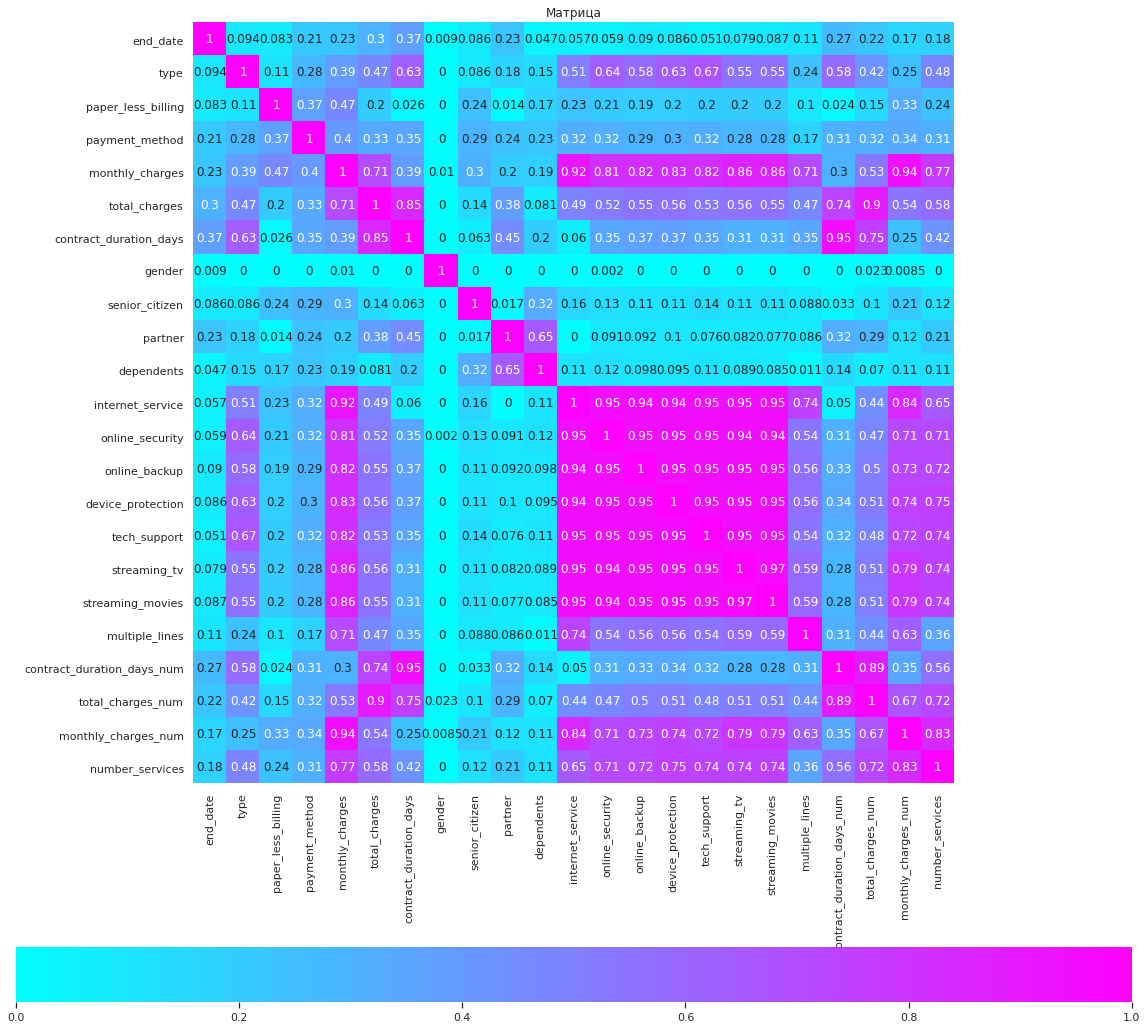

In [103]:
sns.set(rc = {'figure.figsize':(20, 20)})

sns.heatmap(df_phik, annot = True, fmt='.2g', cmap = 'cool', square=True, cbar_kws= {'orientation': 'horizontal'})
plt.title('Матрица')

plt.show()

Посмотрим рейтинг 

In [104]:
df_phik['end_date'].sort_values(ascending=False)

end_date                      1.000000
contract_duration_days        0.374361
total_charges                 0.304151
contract_duration_days_num    0.265742
partner                       0.226776
monthly_charges               0.226314
total_charges_num             0.223543
payment_method                0.214624
number_services               0.182493
monthly_charges_num           0.167960
multiple_lines                0.105152
type                          0.094073
online_backup                 0.089683
streaming_movies              0.086546
senior_citizen                0.085995
device_protection             0.085582
paper_less_billing            0.083159
streaming_tv                  0.078503
online_security               0.058587
internet_service              0.056527
tech_support                  0.051437
dependents                    0.046841
gender                        0.009029
Name: end_date, dtype: float64

**Вывод**<br>&nbsp;&nbsp;&nbsp;&nbsp; После добавления интервалов и новых столбцов можно уже откорректировать данные для машинного обучения.<br> &nbsp;&nbsp;&nbsp;&nbsp; Самая низкая корреляция у признака 'gender', удалим его.<br>&nbsp;&nbsp;&nbsp;&nbsp;Мы видим высокую корреляцию между contract_duration_days и contract_duration_days_num, это одни и те же данные, просто в contract_duration_days_num они разбиты на интервалы. И так как в рейтинге contract_duration_days стоит выше, то в рабочей таблице data оставим его. <br> &nbsp;&nbsp;&nbsp;&nbsp; В признаках 'total_charges', 'monthly_charges' и 'total_charges_num', 'monthly_charges_num' будем смлотреть на матрицу корредяции и метрики модели.<br>&nbsp;&nbsp;&nbsp;&nbsp; Высокая корреляция у всех видов интернет-услуг ('online_security', 'online_backup', 'device_protection', 'tech_support', streaming_tv', 'streaming_movies'). &nbsp;&nbsp;&nbsp;&nbsp; Между ежемесячными тратами 'monthly_charges' и количеством услуг number_services тоже высокая корреляция, так как траты напрямую зависят от количества, но удалять 'monthly_charges' не будем.

#### Анализ данных для обучения модели

In [105]:
data = df.copy()

In [106]:
data.columns

Index(['end_date', 'type', 'paper_less_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'contract_duration_days', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines',
       'contract_duration_days_num', 'total_charges_num',
       'monthly_charges_num', 'number_services'],
      dtype='object')

In [107]:
len(data.columns)

23

In [108]:
data_col_num = data.select_dtypes(include=[int, float]).columns
data_col_num

Index(['end_date', 'monthly_charges', 'total_charges',
       'contract_duration_days', 'number_services'],
      dtype='object')

In [109]:
len(data_col_num)

5

In [110]:
data_col_categor = data.select_dtypes(exclude=[int, float]).columns
data_col_categor

Index(['type', 'paper_less_billing', 'payment_method', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines',
       'contract_duration_days_num', 'total_charges_num',
       'monthly_charges_num'],
      dtype='object')

In [111]:
len(data_col_categor)

18

Посмотрим на графиках зависимость каждого признака от целевого признака:

In [112]:
# функция для создадия таблицы сопряженности
# в параметр index мы передадим признак, в columns - целевой признак

# normalize='index' - отображает проценты каждого значения относительно общего числа строк

def tabl(row):
    display(pd.crosstab(index = data[row], columns = data['end_date'], normalize='index'))

In [113]:
# функция для построения графика зависимости от целевого признака для категориальных признаков

def plot_count(row):
    
    sns.set(rc = {'figure.figsize':(8, 3)})
    print(f'Для признака {row}')
    print()
    tabl(row)
    print()
    sns.countplot(x = row, hue = 'end_date', data = data)
    plt.rcParams['font.size'] = '11'
    plt.title(f'Зависимость {row} от целевого признака', fontsize=12)
    plt.xlabel(f'{row}')
    plt.ylabel('end_date')
    plt.xticks(rotation=45)
    plt.show()

Для признака type



end_date               0         1
type                              
month_to_month  0.894914  0.105086
one_year        0.787508  0.212492
two_year        0.774956  0.225044

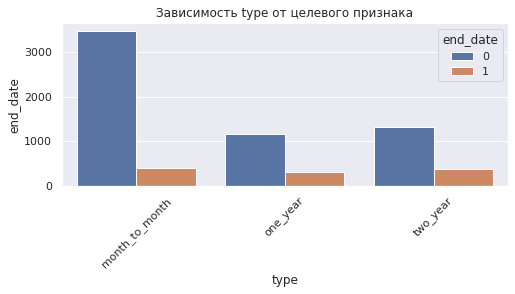

Для признака paper_less_billing



end_date                   0         1
paper_less_billing                    
no                  0.867550  0.132450
yes                 0.827098  0.172902

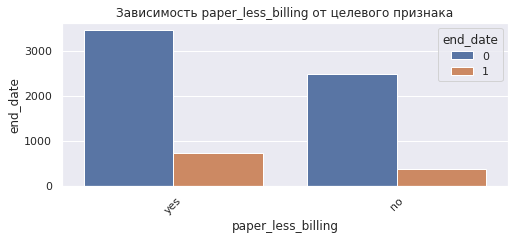

Для признака payment_method



end_date                          0         1
payment_method                               
bank_transfer_(automatic)  0.794689  0.205311
credit_card_(automatic)    0.791584  0.208416
electronic_check           0.852008  0.147992
mailed_check               0.927284  0.072716

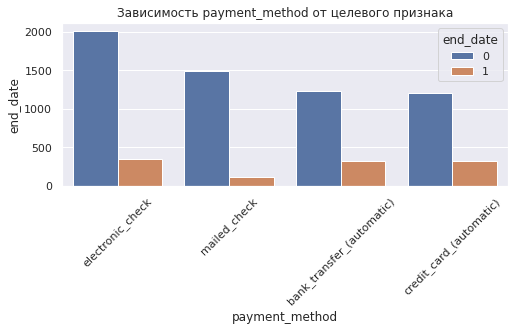

Для признака gender



end_date         0         1
gender                      
female    0.848580  0.151420
male      0.838682  0.161318

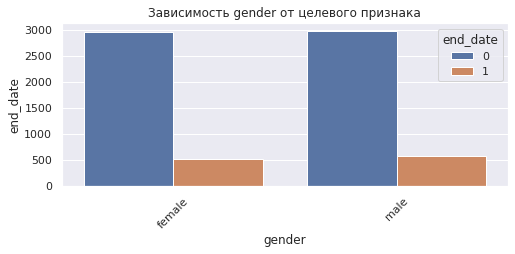

Для признака senior_citizen



end_date               0         1
senior_citizen                    
0               0.852637  0.147363
1               0.796848  0.203152

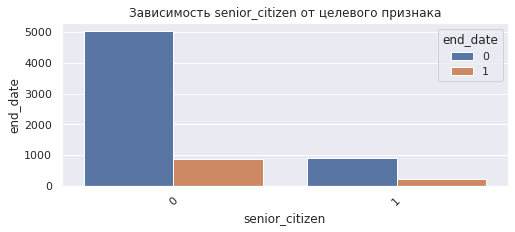

Для признака partner



end_date         0         1
partner                     
no        0.895026  0.104974
yes       0.788529  0.211471

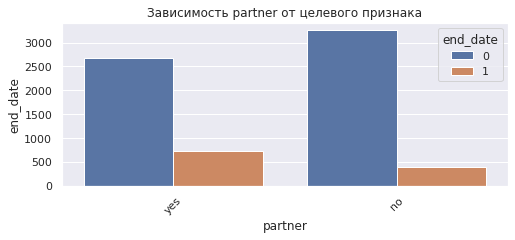

Для признака dependents



end_date           0         1
dependents                    
no          0.851318  0.148682
yes         0.825510  0.174490

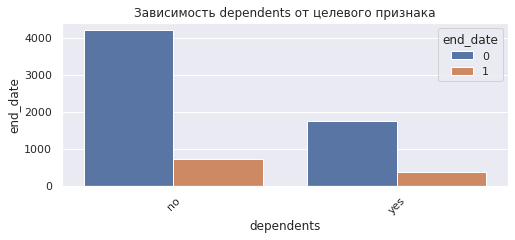

Для признака internet_service



end_date                 0         1
internet_service                    
dsl               0.857084  0.142916
fiber_optic       0.807754  0.192246
no_internet       0.894944  0.105056

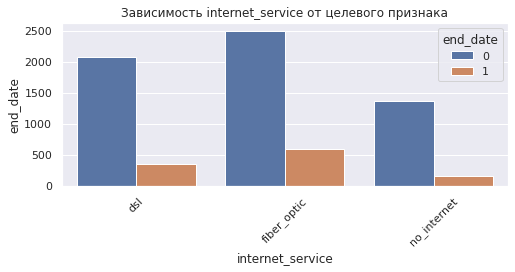

Для признака online_security



end_date                0         1
online_security                    
no               0.849628  0.150372
no_internet      0.894944  0.105056
yes              0.794351  0.205649

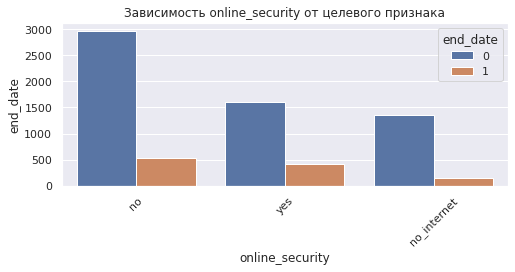

Для признака online_backup



end_date              0         1
online_backup                    
no             0.876619  0.123381
no_internet    0.894944  0.105056
yes            0.769357  0.230643

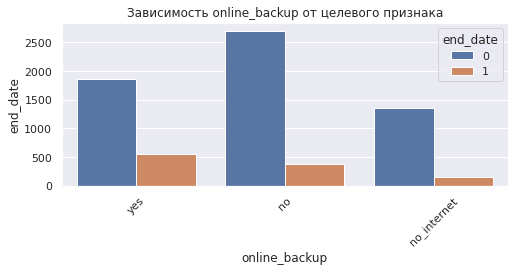

Для признака device_protection



end_date                  0         1
device_protection                    
no                 0.873667  0.126333
no_internet        0.894944  0.105056
yes                0.772821  0.227179

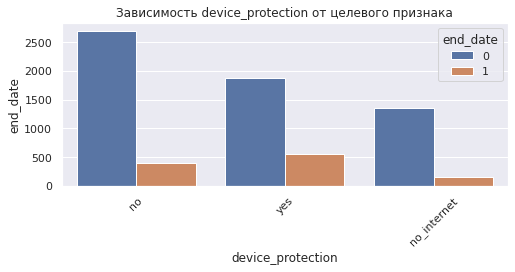

Для признака tech_support



end_date             0         1
tech_support                    
no            0.843651  0.156349
no_internet   0.894944  0.105056
yes           0.805188  0.194812

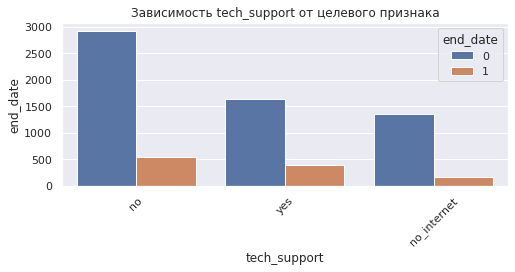

Для признака streaming_tv



end_date             0         1
streaming_tv                    
no            0.872954  0.127046
no_internet   0.894944  0.105056
yes           0.784183  0.215817

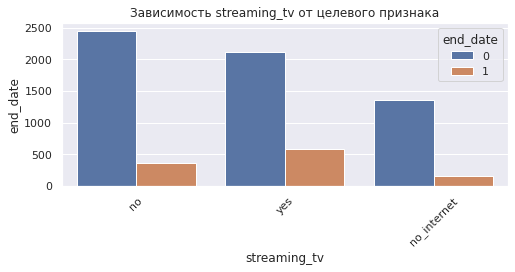

Для признака streaming_movies



end_date                 0         1
streaming_movies                    
no                0.879713  0.120287
no_internet       0.894944  0.105056
yes               0.778103  0.221897

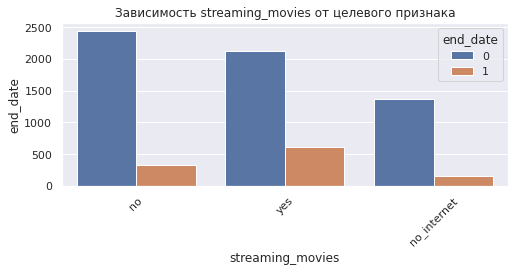

Для признака multiple_lines



end_date                  0         1
multiple_lines                       
no                 0.905549  0.094451
no_multiple_lines  0.848974  0.151026
yes                0.771640  0.228360

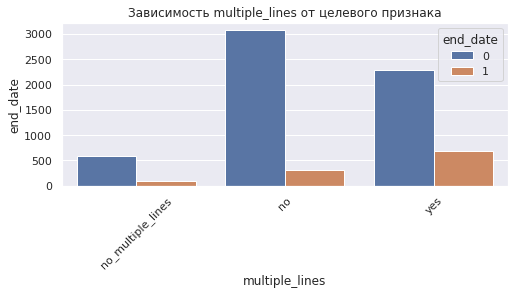

Для признака contract_duration_days_num



end_date                           0         1
contract_duration_days_num                    
1                           0.962993  0.037007
2                           0.897316  0.102684
3                           0.817913  0.182087
4                           0.745182  0.254818
5                           0.681909  0.318091
6                           0.800000  0.200000
7                           0.978788  0.021212

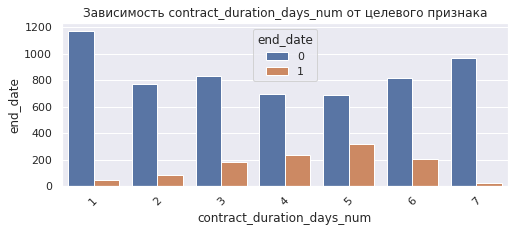

Для признака total_charges_num



end_date                  0         1
total_charges_num                    
2                  0.964179  0.035821
3                  0.920477  0.079523
4                  0.851043  0.148957
5                  0.821891  0.178109
6                  0.740299  0.259701
7                  0.706759  0.293241
8                  0.900498  0.099502

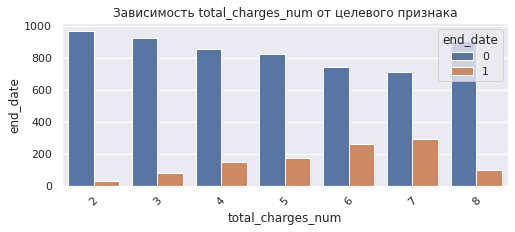

Для признака monthly_charges_num



end_date                    0         1
monthly_charges_num                    
2                    0.921645  0.078355
3                    0.874372  0.125628
4                    0.886000  0.114000
5                    0.886251  0.113749
6                    0.824526  0.175474
7                    0.800397  0.199603
8                    0.710579  0.289421

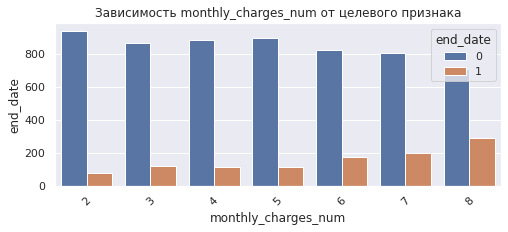

In [114]:
# гисторгаммы для категориальных признаков в порядке рейтинга phik

for k in (data_col_categor):
    plot_count(k)

Наибольший процент оттока клиентов по категориям: <br>
- В признаке gendeer практически нет различия по процентам оттока, поэтому этот признак в дальнейшем удалю<br>
- В признаке partner (наличие супруга(и)) наибольший процент оттока клиентов со статусом ‘yes’.<br>
- В признаке payment_method (способ оплаты) наибольший процент оттока клиентов со способом оплаты bank_transfer_(automatic) и credit_card_(automatic). Оба способа оплаты автоматические.<br>
- В признаке 'multiple_lines' (возможно ли подключение телефонного аппарата к нескольким линиям одновременно) наибольший процент оттока у клиента со статусом yes. <br>
- В признаке 'type' (тип оплаты: ежемесячный, годовой и т.д) – с типом оплаты 1 и 2 года (годовой, двухгодовой).<br>
- В признаке 'senior_citizen' (наличие пенсионного статуса по возрасту) – клиенты со статусом пенсионера.<br>
- В признаке 'paper_less_billing' (электронный платежный документ) – клиенты со статусом yes (подключен).<br>
- В признаке 'dependents' (наличие иждивенцев) – клиенты со статусом yes, хотя разница с no уже не очень существенная.<br>
- В признаке 'internet_service' (интернет-сервис, подключение может быть двух типов: DSL (digital subscriber line) - цифровая абонентская линия или Fiber optic - оптоволоконный кабель) – отток у клиентов с fiber_optic.<br>
- В признаке  online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies – наибольший процент у клиентов с подключенными услугами. <br>
- Для интервальных столбцов наибольший отткок: total_charges_num соответствует интервалам 6 и 7 (соответствует суммам 1699.0 - 2862.32 и 2862.32 - 4690.29), monthly_charges_num соответствует интервалу 8 (суммы 99.1 - 118.75), увеличивается с увеличением суммы ежемесячных трат на услуги, в contract_duration_days с продолжительностью контракта 1000 дней, что выше среднего значения показателя contract_duration_days.<br>

In [115]:
def dis_plot(row):
    #plt.rcParams['font.size'] = '15'
    #sns.set(rc = {'figure.figsize':(8, 3)})
    sns.displot(data, x = row, hue = 'end_date', kind = 'hist')
    print()
    plt.title(f'Зависимость {row} от целевого признака', fontsize=12)
    print()
    plt.xlabel(f'{row}')
    plt.ylabel('density')
    plt.show()

In [116]:
def box_plot(row):
    sns.boxplot(x = 'end_date', y = row, data = data)
    print()
    plt.title(f'Зависимость {row} от целевого признака', fontsize=12)
    print()
    plt.xlabel(f'{row}')
    plt.ylabel(row)
    plt.show()

In [117]:
def histogram(row):
    sns.histplot(data[row], bins=70, kde=True)
    plt.title(f'Распределение {row}')
    plt.xlabel(f'{row}')
    plt.ylabel('частота')
    plt.show()

In [118]:
data_col_nums = ['monthly_charges', 'total_charges',
       'contract_duration_days', 'number_services']


Для monthly_charges


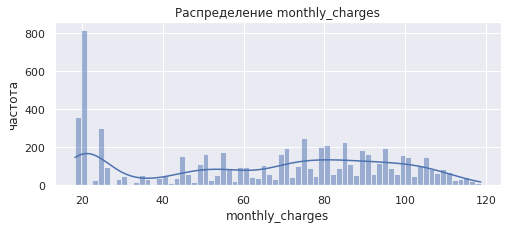

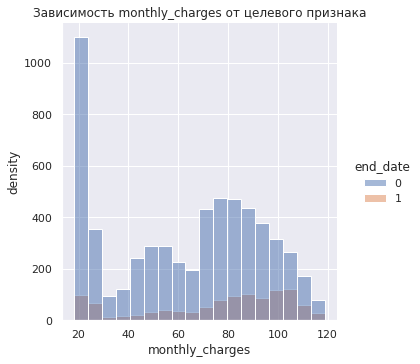

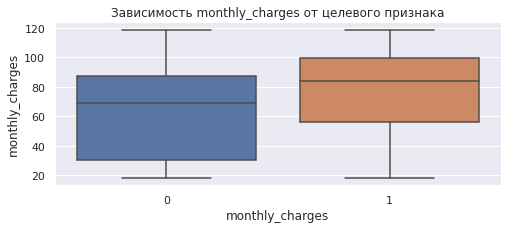


Для total_charges


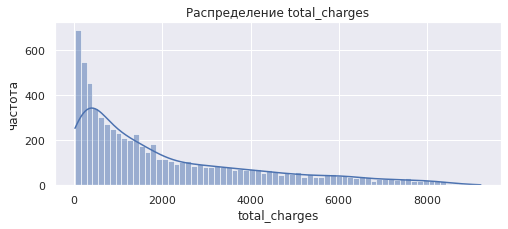

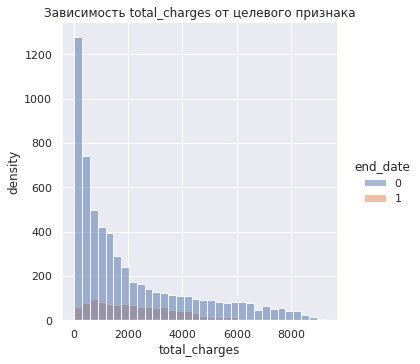

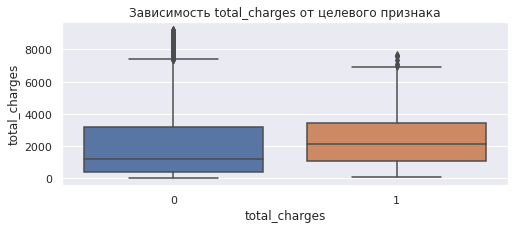


Для contract_duration_days


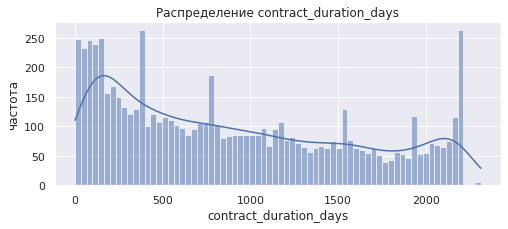

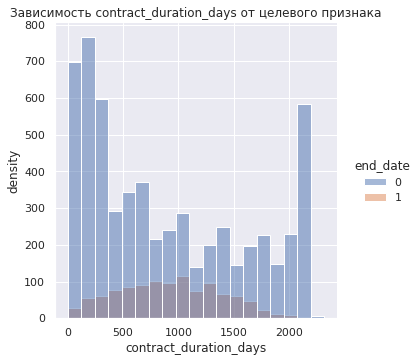

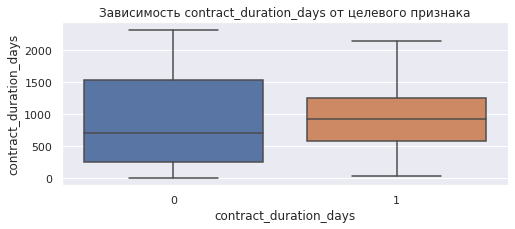


Для number_services


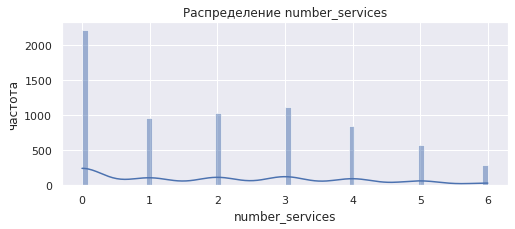

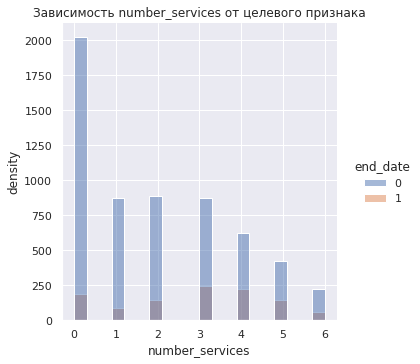

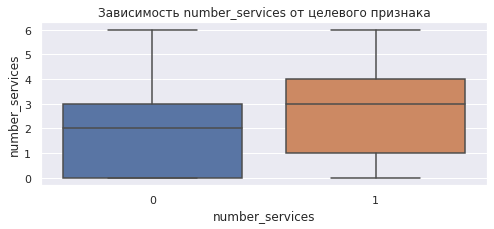

In [119]:
# построим графики плотности распределений признаков

for z in (data_col_nums):
    print()
    plt.rcParams['font.size'] = '15'
    sns.set(rc = {'figure.figsize':(8, 3)})
    print(f'Для {z}')
    histogram(z)
    dis_plot(z)
    box_plot(z)

В contract_duration_days с продолжительностью контракта 1000 дней, что выше среднего значения показателя contract_duration_days (среднее значение в столбце количества дней составляет 942.806612, медиана 822). Реже всего разрываются долгосрочные контракты. В 'number_services' (количество подключенных услуг клиента) – у клиентов с 3-4 подключенными услугами. Большинство подключенных услуг влияют на ежемесячные траты и существенно их увеличивают, поэтому повышается риск оттока клиентов. В total_charges (видно на гистограмме интервалов) наибольший отток у клиентов с суммой расходов в районе 2000, наибольшие проценты относятся к интервалам 6 и 7, что соответствует суммам 1699.0 - 2862.32 и 2862.32 - 4690.29.
В признаке monthly_charges_num (ежемесячные платежи) отток клиентов увеличивпется с увеличением суммы ежемесячных трат на услуги. Набольший процент в 7 и 8 диапазонах, что соответствует суммам 86.5 - 99.1 и 99.1 - 118.75.

In [120]:
data = data.drop(['gender',
                  'contract_duration_days_num',
                  'total_charges_num', 
                  'monthly_charges_num',
                  'internet_service',
                  #'online_security', 
                  #'online_backup', 
                  #'device_protection',
                  #'tech_support', 
                  #'streaming_tv', 
                  #'streaming_movies',
                  #'number_services'
                 ], 
          axis=1
         )

In [121]:
data .duplicated().sum()

8

В результате удаления столбцов и разбиения на интервалы в таблице появились дубликаты. Удаляем.

In [122]:
data = data.drop_duplicates()

In [123]:
dataset3(data)


Общая информация

<class 'pandas.core.frame.DataFrame'>
Index: 7031 entries, 7590-vhveg to 3186-ajiek
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   end_date                7031 non-null   int64  
 1   type                    7031 non-null   object 
 2   paper_less_billing      7031 non-null   object 
 3   payment_method          7031 non-null   object 
 4   monthly_charges         7031 non-null   float64
 5   total_charges           7031 non-null   float64
 6   contract_duration_days  7031 non-null   int64  
 7   senior_citizen          7031 non-null   object 
 8   partner                 7031 non-null   object 
 9   dependents              7031 non-null   object 
 10  online_security         7031 non-null   object 
 11  online_backup           7031 non-null   object 
 12  device_protection       7031 non-null   object 
 13  tech_support            7031 non-null   object 
 14  streaming_t

end_date            type paper_less_billing  \
customer_id                                                
7590-vhveg          0  month_to_month                yes   
5575-gnvde          0        one_year                 no   
3668-qpybk          0  month_to_month                yes   
7795-cfocw          0        one_year                 no   
9237-hqitu          0  month_to_month                yes   

                        payment_method  monthly_charges  total_charges  \
customer_id                                                              
7590-vhveg            electronic_check            29.85          31.04   
5575-gnvde                mailed_check            56.95        2071.84   
3668-qpybk                mailed_check            53.85         226.17   
7795-cfocw   bank_transfer_(automatic)            42.30        1960.60   
9237-hqitu            electronic_check            70.70         353.50   

             contract_duration_days senior_citizen partner dependents  \
customer_id                                                             
7590-vhveg                       31              0     yes         no   
5575-gnvde                     1036              0      no         no   
3668-qpybk                      123              0      no         no   
7795-cfocw                     1371              0      no         no   
9237-hqitu                      153              0      no         no   

            online_security online_backup device_protection tech_support  \
customer_id                                                                
7590-vhveg               no           yes                no           no   
5575-gnvde              yes            no               yes           no   
3668-qpybk              yes           yes                no           no   
7795-cfocw              yes            no               yes          yes   
9237-hqitu               no            no                no           no   

            streaming_tv streaming_movies     multiple_lines  number_services  
customer_id                                                                    
7590-vhveg            no               no  no_multiple_lines                1  
5575-gnvde            no               no                 no                2  
3668-qpybk            no               no                 no                2  
7795-cfocw            no               no  no_multiple_lines                3  
9237-hqitu            no               no                 no                0


Выборочно 10 строк


end_date            type paper_less_billing  \
customer_id                                                
6407-utslv          0  month_to_month                yes   
7558-imlmt          0        two_year                yes   
8234-gszyk          1        two_year                 no   
0516-uxrmt          0        one_year                yes   
1488-pbljn          0        two_year                yes   
9091-wtuuy          0        two_year                 no   
4361-febgn          0        two_year                 no   
1958-rnrks          0  month_to_month                 no   
0423-udijq          0  month_to_month                 no   
3668-qpybk          0  month_to_month                yes   

                        payment_method  monthly_charges  total_charges  \
customer_id                                                              
6407-utslv   bank_transfer_(automatic)            83.80         177.66   
7558-imlmt                mailed_check            20.80        1519.02   
8234-gszyk   bank_transfer_(automatic)            26.45        1045.30   
0516-uxrmt            electronic_check            92.05        5707.10   
1488-pbljn   bank_transfer_(automatic)           116.85        8413.20   
9091-wtuuy                mailed_check            69.25        4742.24   
4361-febgn     credit_card_(automatic)            20.15         967.20   
1958-rnrks            electronic_check            49.90        1616.76   
0423-udijq                mailed_check            49.20         478.22   
3668-qpybk                mailed_check            53.85         226.17   

             contract_duration_days senior_citizen partner dependents  \
customer_id                                                             
6407-utslv                       62              1      no         no   
7558-imlmt                     2041              0     yes        yes   
8234-gszyk                     1157              0      no         no   
0516-uxrmt                     1888              0      no         no   
1488-pbljn                     2191              0     yes        yes   
9091-wtuuy                     1949              0     yes        yes   
4361-febgn                     1461              0      no         no   
1958-rnrks                      914              0     yes         no   
0423-udijq                      276              1      no         no   
3668-qpybk                      123              0      no         no   

            online_security online_backup device_protection tech_support  \
customer_id                                                                
6407-utslv               no           yes                no           no   
7558-imlmt      no_internet   no_internet       no_internet  no_internet   
8234-gszyk      no_internet   no_internet       no_internet  no_internet   
0516-uxrmt              yes           yes               yes           no   
1488-pbljn              yes           yes               yes          yes   
9091-wtuuy              yes            no               yes          yes   
4361-febgn      no_internet   no_internet       no_internet  no_internet   
1958-rnrks               no            no                no           no   
0423-udijq               no            no                no          yes   
3668-qpybk              yes           yes                no           no   

            streaming_tv streaming_movies multiple_lines  number_services  
customer_id                                                                
6407-utslv           yes               no             no                2  
7558-imlmt   no_internet      no_internet             no                0  
8234-gszyk   no_internet      no_internet            yes                0  
0516-uxrmt            no               no            yes                3  
1488-pbljn           yes              yes            yes                6  
9091-wtuuy           yes               no             no                4  
4361-


Количество пропусков:


end_date                  0
type                      0
paper_less_billing        0
payment_method            0
monthly_charges           0
total_charges             0
contract_duration_days    0
senior_citizen            0
partner                   0
dependents                0
online_security           0
online_backup             0
device_protection         0
tech_support              0
streaming_tv              0
streaming_movies          0
multiple_lines            0
number_services           0
dtype: int64


Количество дубликатов


0


Список столбцов
Index(['end_date', 'type', 'paper_less_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'contract_duration_days',
       'senior_citizen', 'partner', 'dependents', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines', 'number_services'],
      dtype='object')



end_date  monthly_charges  total_charges  contract_duration_days  \
count  7031.000000      7031.000000    7031.000000             7031.000000   
mean      0.156592        64.823524    2117.287100              899.053762   
std       0.363442        30.059460    2111.923944              682.574911   
min       0.000000        18.250000      19.050000                0.000000   
25%       0.000000        35.725000     438.750000              276.000000   
50%       0.000000        70.350000    1344.000000              761.000000   
75%       0.000000        89.850000    3238.695000             1461.000000   
max       1.000000       118.750000    9221.380000             2314.000000   

       number_services  
count      7031.000000  
mean          2.040535  
std           1.846894  
min           0.000000  
25%           0.000000  
50%           2.000000  
75%           3.000000  
max           6.000000

In [124]:
data_phik = data.phik_matrix()
data_phik

interval columns not set, guessing: ['end_date', 'monthly_charges', 'total_charges', 'contract_duration_days', 'number_services']


end_date      type  paper_less_billing  \
end_date                1.000000  0.094011            0.082489   
type                    0.094011  1.000000            0.107388   
paper_less_billing      0.082489  0.107388            1.000000   
payment_method          0.213984  0.277438            0.368329   
monthly_charges         0.225880  0.389085            0.465838   
total_charges           0.303843  0.467903            0.201474   
contract_duration_days  0.374087  0.633497            0.023629   
senior_citizen          0.085667  0.086400            0.241446   
partner                 0.226381  0.179107            0.015788   
dependents              0.046547  0.147237            0.174221   
online_security         0.058271  0.637606            0.207545   
online_backup           0.089465  0.582573            0.194390   
device_protection       0.085355  0.632285            0.194774   
tech_support            0.051083  0.672270            0.199773   
streaming_tv            0.078254  0.550619            0.203792   
streaming_movies        0.086318  0.554594            0.201307   
multiple_lines          0.104955  0.242792            0.099425   
number_services         0.182159  0.484386            0.234094   

                        payment_method  monthly_charges  total_charges  \
end_date                      0.213984         0.225880       0.303843   
type                          0.277438         0.389085       0.467903   
paper_less_billing            0.368329         0.465838       0.201474   
payment_method                1.000000         0.397747       0.333869   
monthly_charges               0.397747         1.000000       0.710506   
total_charges                 0.333869         0.710506       1.000000   
contract_duration_days        0.349867         0.387013       0.847443   
senior_citizen                0.291824         0.304316       0.137078   
partner                       0.241202         0.203122       0.379593   
dependents                    0.225715         0.186511       0.080205   
online_security               0.314459         0.812679       0.515421   
online_backup                 0.291942         0.818908       0.549625   
device_protection             0.296469         0.827329       0.557767   
tech_support                  0.316382         0.816703       0.526902   
streaming_tv                  0.283050         0.864746       0.554760   
streaming_movies              0.284046         0.863685       0.553663   
multiple_lines                0.174107         0.710007       0.466754   
number_services               0.309809         0.770984       0.584339   

                        contract_duration_days  senior_citizen   partner  \
end_date                              0.374087        0.085667  0.226381   
type                                  0.633497        0.086400  0.179107   
paper_less_billing                    0.023629        0.241446  0.015788   
payment_method                        0.349867        0.291824  0.241202   
monthly_charges                       0.387013        0.304316  0.203122   
total_charges                         0.847443        0.137078  0.379593   
contract_duration_days                1.000000        0.062872  0.451770   
senior_citizen                        0.062872        1.000000  0.016181   
partner                               0.451770        0.016181  1.000000   
dependents                            0.196958        0.325151  0.651525   
online_security                       0.346182        0.126988  0.091100   
online_backup                         0.366052        0.109616  0.091916   
device_protection                     0.374617        0.109798  0.100003   
tech_support                          0.353257        0.134973  0.076210   
streaming_tv                          0.306409        0.111343  0.082148   
streaming_movies                      0.307050        0.113415  0.077398   
multiple_lines                        0.346399        0.087758  0.0856

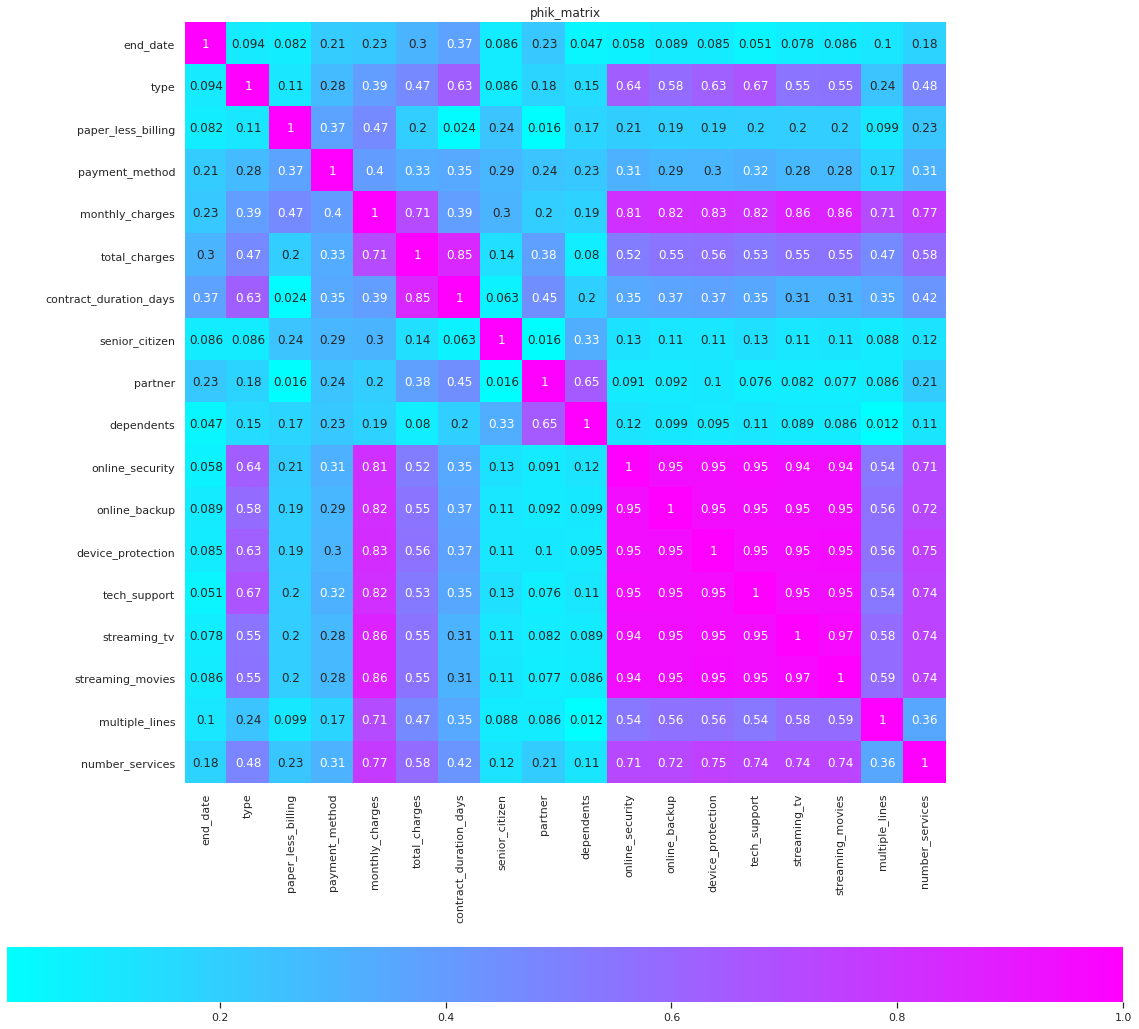

In [125]:
sns.set(rc = {'figure.figsize':(20, 20)})

sns.heatmap(data_phik, annot = True, fmt='.2g', cmap = 'cool', square=True, cbar_kws= {'orientation': 'horizontal'})
plt.title('phik_matrix')

plt.show()

Посмотрим рейтинг 

In [126]:
data_phik['end_date'].sort_values(ascending=False)

end_date                  1.000000
contract_duration_days    0.374087
total_charges             0.303843
partner                   0.226381
monthly_charges           0.225880
payment_method            0.213984
number_services           0.182159
multiple_lines            0.104955
type                      0.094011
online_backup             0.089465
streaming_movies          0.086318
senior_citizen            0.085667
device_protection         0.085355
paper_less_billing        0.082489
streaming_tv              0.078254
online_security           0.058271
tech_support              0.051083
dependents                0.046547
Name: end_date, dtype: float64

In [127]:
data.describe()

end_date  monthly_charges  total_charges  contract_duration_days  \
count  7031.000000      7031.000000    7031.000000             7031.000000   
mean      0.156592        64.823524    2117.287100              899.053762   
std       0.363442        30.059460    2111.923944              682.574911   
min       0.000000        18.250000      19.050000                0.000000   
25%       0.000000        35.725000     438.750000              276.000000   
50%       0.000000        70.350000    1344.000000              761.000000   
75%       0.000000        89.850000    3238.695000             1461.000000   
max       1.000000       118.750000    9221.380000             2314.000000   

       number_services  
count      7031.000000  
mean          2.040535  
std           1.846894  
min           0.000000  
25%           0.000000  
50%           2.000000  
75%           3.000000  
max           6.000000

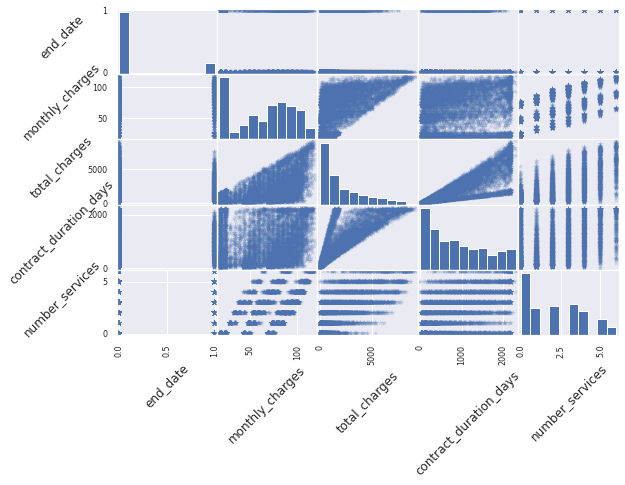

In [128]:
# Попарная точечная диаграмма для числовых признаков
sm = pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(9, 6), diagonal='hist', ax=None, grid=False, 
                                marker='*', density_kwds=None, hist_kwds=None, range_padding=0.05)
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]
plt.show()

**Вывод**<br>Получили следующие данные.<br> Таблица data размером (7031, 18). Кoличество ячееек: 126558. 5 количественных столбца и 13 категориальных. .<br>Пропуков нет, дубликаты удадены.<br><br>
Посмотрим рейтинг phik<br><br>

end_date                  1.000000<br>
contract_duration_days    0.374087<br>
total_charges             0.303843<br>
partner                   0.226381<br>
monthly_charges           0.225880<br>
payment_method            0.213984<br>
number_services           0.182159<br>
multiple_lines            0.104955<br>
type                      0.094011<br>
online_backup             0.089465<br>
streaming_movies          0.086318<br>
senior_citizen            0.085667<br>
device_protection         0.085355<br>
paper_less_billing        0.082489<br>
streaming_tv              0.078254<br>
online_security           0.058271<br>
tech_support              0.051083<br>
dependents                0.046547
<br><br>

Наибольший процент оттока клиентов по категориям:<br>
В признаке partner (наличие супруга(и)) наибольший процент оттока клиентов со статусом ‘yes’.<br>
В признаке payment_method (способ оплаты) наибольший процент оттока клиентов со способом оплаты bank_transfer_(automatic)  и credit_card_(automatic). Оба способа оплаты автоматические.<br>

В признаке 'multiple_lines' (возможно ли подключение телефонного аппарата к нескольким линиям одновременно) наибольший процент оттока у клиента со статусом yes.<br>
В признаке 'type' (тип оплаты: ежемесячный, годовой и т.д) – с типом оплаты 1 и 2 года (годовой, двухгодовой).<br>
В признаке 'senior_citizen' (наличие пенсионного статуса по возрасту) – клиенты со статусом пенсионера.<br>
В признаке 'paper_less_billing' (электронный платежный документ) – клиенты со статусом yes (подключен).<br>
В признаке 'internet_service' (интернет-сервис, подключение может быть двух типов: DSL (digital subscriber line) - цифровая абонентская линия или Fiber optic - оптоволоконный кабель) – отток у клиентов с fiber_optic.<br>
В признаке 'dependents' (наличие иждивенцев) – клиенты со статусом yes, хотя разница с no уже не очень существенная.<br><br>

В числовых признаках наибольший отток клиентов наблюдается:<br><br>
В contract_duration_days с продолжительностью контракта 1000 дней, что выше среднего значения показателя contract_duration_days
(среднее значение в столбце количества дней составляет 942.806612, медиана 822). Реже всего разрываются долгосрочные контракты.<br>
В 'number_services' (количество подключенных услуг клиента) – у клиентов с 3-4 подключенными услугами. Большинство подключенных услуг влияют на ежемесячные траты и существенно их увеличивают, поэтому повышается риск оттока клиентов.<br>
В total_charges (видно на гистограмме интервалов) наибольший отток у клиентов с суммой расходов в районе 2000, наибольшие проценты относятся к интервалам 6 и 7, что соответствует суммам 1699.0 - 2862.32 и 2862.32 <- 4690.29.<br> В признаке monthly_charges_num (ежемесячные платежи) отток клиентов увеличивпется с увеличением суммы ежемесячных трат на услуги. Набольший процент в 7 и 8 диапазонах, что соответствует суммам 86.5 - 99.1 и 99.1 - 118.75<br>


### Подготовка данных к машинному обучению

In [129]:
data.head(3)

end_date            type paper_less_billing    payment_method  \
customer_id                                                                  
7590-vhveg          0  month_to_month                yes  electronic_check   
5575-gnvde          0        one_year                 no      mailed_check   
3668-qpybk          0  month_to_month                yes      mailed_check   

             monthly_charges  total_charges  contract_duration_days  \
customer_id                                                           
7590-vhveg             29.85          31.04                      31   
5575-gnvde             56.95        2071.84                    1036   
3668-qpybk             53.85         226.17                     123   

            senior_citizen partner dependents online_security online_backup  \
customer_id                                                                   
7590-vhveg               0     yes         no              no           yes   
5575-gnvde               0      no         no             yes            no   
3668-qpybk               0      no         no             yes           yes   

            device_protection tech_support streaming_tv streaming_movies  \
customer_id                                                                
7590-vhveg                 no           no           no               no   
5575-gnvde                yes           no           no               no   
3668-qpybk                 no           no           no               no   

                multiple_lines  number_services  
customer_id                                      
7590-vhveg   no_multiple_lines                1  
5575-gnvde                  no                2  
3668-qpybk                  no                2

In [130]:
len(data.columns)

18

In [131]:
len(df.columns)

23

#### Разделение данных на выборки

In [132]:
features = data.drop(['end_date'], axis=1)
target = data['end_date']

In [133]:
features.shape

(7031, 17)

In [134]:
target.shape

(7031,)

In [135]:
# задать пропорцию классов при разделении на обучающий и тестовый датасеты с помощью параметра stratify 
# будем стратифицировать в соответствии распределению по классам в tarset.

train, test = train_test_split(data,
                               test_size=0.25,
                               random_state=RANDOM_STATE,
                               stratify=data['end_date'])

**----- Исходные признаки**

In [136]:
# признаки для обучающей выборки

features_train = train.drop(['end_date'], axis=1)
target_train = train['end_date']

In [137]:
# признаки для тестовой выборки

features_test = test.drop(['end_date'], axis=1)
target_test = test['end_date']

In [138]:
display(features_train.head(3))
display(features_test.head(3))

type paper_less_billing             payment_method  \
customer_id                                                                 
1066-jksgk   month_to_month                 no               mailed_check   
3737-xbqdd   month_to_month                yes  bank_transfer_(automatic)   
0080-emyvy         one_year                 no    credit_card_(automatic)   

             monthly_charges  total_charges  contract_duration_days  \
customer_id                                                           
1066-jksgk             20.15          61.05                      92   
3737-xbqdd             84.85        1781.85                     638   
0080-emyvy             51.45         720.30                     427   

            senior_citizen partner dependents online_security online_backup  \
customer_id                                                                   
1066-jksgk               0      no         no     no_internet   no_internet   
3737-xbqdd               0      no         no              no           yes   
0080-emyvy               0      no         no              no           yes   

            device_protection tech_support streaming_tv streaming_movies  \
customer_id                                                                
1066-jksgk        no_internet  no_internet  no_internet      no_internet   
3737-xbqdd                yes           no           no               no   
0080-emyvy                 no           no           no               no   

            multiple_lines  number_services  
customer_id                                  
1066-jksgk              no                0  
3737-xbqdd             yes                2  
0080-emyvy              no                1

type paper_less_billing    payment_method  \
customer_id                                                        
7619-odsgn   month_to_month                 no  electronic_check   
5027-xwqha   month_to_month                 no  electronic_check   
5392-akemh   month_to_month                yes  electronic_check   

             monthly_charges  total_charges  contract_duration_days  \
customer_id                                                           
7619-odsgn             54.75        1409.81                     761   
5027-xwqha             44.75         410.81                     276   
5392-akemh             45.05         540.60                     365   

            senior_citizen partner dependents online_security online_backup  \
customer_id                                                                   
7619-odsgn               0     yes        yes             yes            no   
5027-xwqha               0      no         no              no            no   
5392-akemh               0      no         no              no            no   

            device_protection tech_support streaming_tv streaming_movies  \
customer_id                                                                
7619-odsgn                 no           no           no               no   
5027-xwqha                 no           no           no               no   
5392-akemh                 no           no           no               no   

            multiple_lines  number_services  
customer_id                                  
7619-odsgn             yes                1  
5027-xwqha              no                0  
5392-akemh              no                0

In [139]:
print(f'Выборка features_train')
print(features_train.shape)
print('--------------------')
print(f'Выборка features_test')
print(features_test.shape)
print('--------------------')
print(f'Выборка target_train')
print(target_train.shape)
print('--------------------')
print(f'Выборка features_train')
print(target_test.shape)
print('--------------------')
print('Соотношение классов target_train', target_train.value_counts()[0] / target_train.value_counts()[1])
print('Соотношение классов target_test', target_test.value_counts()[0] / target_test.value_counts()[1])

Выборка features_train
(5273, 17)
--------------------
Выборка features_test
(1758, 17)
--------------------
Выборка target_train
(5273,)
--------------------
Выборка features_train
(1758,)
--------------------
Соотношение классов target_train 5.383777239709443
Соотношение классов target_test 5.392727272727273


In [140]:
# список категориальных столбцов

cat_features = list(features_train.select_dtypes(include=object).columns)
cat_features

['type',
 'paper_less_billing',
 'payment_method',
 'senior_citizen',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [141]:
# список категориальных столбцов

categ_features = list(features_train.select_dtypes(include='category').columns)
categ_features

[]

In [142]:
cat_features = cat_features + categ_features
cat_features

['type',
 'paper_less_billing',
 'payment_method',
 'senior_citizen',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [143]:
# список числовых столбцов

num_features = features_train.select_dtypes(include=[int, float]).columns
num_features

Index(['monthly_charges', 'total_charges', 'contract_duration_days',
       'number_services'],
      dtype='object')

In [144]:
len(cat_features)

13

In [145]:
len(num_features)

4

**--------Кодировка**

In [147]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[cat_features])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[cat_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(cat_features, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features] = scaler.fit_transform(features_train[num_features])

# смотрим на результат
features_train.head()

monthly_charges  total_charges  contract_duration_days  \
customer_id                                                           
1066-jksgk         -1.500246      -0.972268               -1.179753   
3737-xbqdd          0.649294      -0.167295               -0.382077   
0080-emyvy         -0.460360      -0.663877               -0.690336   
7486-ksrvi          1.152625       0.683217                0.285574   
4138-naxed          0.521385       1.008911                0.954686   

             number_services  type_one_year  type_two_year  \
customer_id                                                  
1066-jksgk         -1.114787            0.0            0.0   
3737-xbqdd         -0.039067            0.0            0.0   
0080-emyvy         -0.576927            1.0            0.0   
7486-ksrvi          0.498793            1.0            0.0   
4138-naxed         -0.576927            0.0            0.0   

             paper_less_billing_yes  payment_method_credit_card_(automatic)  \
customer_id                                                                   
1066-jksgk                      0.0                                     0.0   
3737-xbqdd                      1.0                                     0.0   
0080-emyvy                      0.0                                     1.0   
7486-ksrvi                      1.0                                     0.0   
4138-naxed                      0.0                                     0.0   

             payment_method_electronic_check  payment_method_mailed_check  \
customer_id                                                                 
1066-jksgk                               0.0                          1.0   
3737-xbqdd                               0.0                          0.0   
0080-emyvy                               0.0                          0.0   
7486-ksrvi                               1.0                          0.0   
4138-naxed                               0.0                          0.0   

             ...  device_protection_no_internet  device_protection_yes  \
customer_id  ...                                                         
1066-jksgk   ...                            1.0                    0.0   
3737-xbqdd   ...                            0.0                    1.0   
0080-emyvy   ...                            0.0                    0.0   
7486-ksrvi   ...                            0.0                    0.0   
4138-naxed   ...                            0.0                    0.0   

             tech_support_no_internet  tech_support_yes  \
customer_id                                               
1066-jksgk                        1.0               0.0   
3737-xbqdd                        0.0               0.0   
0080-emyvy                        0.0               0.0   
7486-ksrvi                        0.0               1.0   
4138-naxed                        0.0               0.0   

             streaming_tv_no_internet  streaming_tv_yes  \
customer_id                                               
1066-jksgk                        1.0               0.0   
3737-xbqdd                        0.0               0.0   
0080-emyvy                        0.0               0.0   
7486-ksrvi                        0.0               1.0   
4138-naxed                        0.0               0.0   

             streaming_movies_no_internet  streaming_movies_yes  \
customer_id                                                       
1066-jksgk                            1.0                   0.0   
3737-xbqdd                            0.0                   0.0   
0080-emyvy                            0.0                   0.0   
7486-ksrvi                            0.0                   1.0   
4138-naxed                            0.0                   0.0   

             multiple_lines_no_multiple_lines  multiple_lines_yes  
customer_id                                                        
1066-jksgk                       

In [148]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[cat_features])

features_test = features_test.drop(cat_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
features_test[num_features] = scaler.transform(
    features_test[num_features]
)

# смотрим на результат
features_test.head()

monthly_charges  total_charges  contract_duration_days  \
customer_id                                                           
7619-odsgn         -0.350724      -0.341332               -0.202381   
5027-xwqha         -0.682956      -0.808654               -0.910939   
5392-akemh         -0.672989      -0.747939               -0.780915   
2418-tpeun         -1.511874      -0.482141                1.178210   
8329-utmvm          1.307113       0.334157               -0.113264   

             number_services  type_one_year  type_two_year  \
customer_id                                                  
7619-odsgn         -0.576927            0.0            0.0   
5027-xwqha         -1.114787            0.0            0.0   
5392-akemh         -1.114787            0.0            0.0   
2418-tpeun         -1.114787            0.0            1.0   
8329-utmvm          1.036653            1.0            0.0   

             paper_less_billing_yes  payment_method_credit_card_(automatic)  \
customer_id                                                                   
7619-odsgn                      0.0                                     0.0   
5027-xwqha                      0.0                                     0.0   
5392-akemh                      1.0                                     0.0   
2418-tpeun                      1.0                                     1.0   
8329-utmvm                      1.0                                     0.0   

             payment_method_electronic_check  payment_method_mailed_check  \
customer_id                                                                 
7619-odsgn                               1.0                          0.0   
5027-xwqha                               1.0                          0.0   
5392-akemh                               1.0                          0.0   
2418-tpeun                               0.0                          0.0   
8329-utmvm                               0.0                          0.0   

             ...  device_protection_no_internet  device_protection_yes  \
customer_id  ...                                                         
7619-odsgn   ...                            0.0                    0.0   
5027-xwqha   ...                            0.0                    0.0   
5392-akemh   ...                            0.0                    0.0   
2418-tpeun   ...                            1.0                    0.0   
8329-utmvm   ...                            0.0                    0.0   

             tech_support_no_internet  tech_support_yes  \
customer_id                                               
7619-odsgn                        0.0               0.0   
5027-xwqha                        0.0               0.0   
5392-akemh                        0.0               0.0   
2418-tpeun                        1.0               0.0   
8329-utmvm                        0.0               1.0   

             streaming_tv_no_internet  streaming_tv_yes  \
customer_id                                               
7619-odsgn                        0.0               0.0   
5027-xwqha                        0.0               0.0   
5392-akemh                        0.0               0.0   
2418-tpeun                        1.0               0.0   
8329-utmvm                        0.0               1.0   

             streaming_movies_no_internet  streaming_movies_yes  \
customer_id                                                       
7619-odsgn                            0.0                   0.0   
5027-xwqha                            0.0                   0.0   
5392-akemh                            0.0                   0.0   
2418-tpeun                            1.0                   0.0   
8329-utmvm                            0.0                   1.0   

             multiple_lines_no_multiple_lines  multiple_lines_yes  
customer_id                                                        
7619-odsgn                       

In [149]:
print(f'Выборка features_train')
print(features_train.shape)
print('--------------------')
print(f'Выборка features_test')
print(features_test.shape)
print('--------------------')
print(f'Выборка target_train')
print(target_train.shape)
print('--------------------')
print(f'Выборка features_train')
print(target_test.shape)
print('--------------------')
print('Соотношение классов target_train', target_train.value_counts()[0] / target_train.value_counts()[1])
print('Соотношение классов target_test', target_test.value_counts()[0] / target_test.value_counts()[1])

Выборка features_train
(5273, 27)
--------------------
Выборка features_test
(1758, 27)
--------------------
Выборка target_train
(5273,)
--------------------
Выборка features_train
(1758,)
--------------------
Соотношение классов target_train 5.383777239709443
Соотношение классов target_test 5.392727272727273


### Обучение моделей

In [150]:
cv_counts = 5

#### LogisticRegression

In [151]:
%%time
start_lr = time.time()

# Предварительная обработка с использованием make_column_transformer
#preprocessor_lr = make_column_transformer((StandardScaler(), num_features), # количественные
                                          #(OneHotEncoder(), cat_features))  # категориальные

# Создание конвейера с предварительной обработкой и логистической регрессией

pipeline_lr = Pipeline([
    #('scaler', preprocessor_lr),
    ('lr', LogisticRegression(random_state=RANDOM_STATE))
    ])                                          
params_lr = {'lr__penalty': ['l1', 'l2'],
             'lr__C': [0.001, 0.01, 0.1, 1, 2],
             'lr__class_weight': [None, 'balanced'],
             }

model_lr = GridSearchCV(pipeline_lr, 
                        params_lr, 
                        cv = cv_counts,
                        scoring= 'roc_auc',
                        verbose=300,
                        n_jobs=-1,
                        refit=True)

model_lr.fit(features_train, target_train)

end_lr = time.time()
time_fit_lr = end_lr - start_lr
print('Время выполнения lr:', time_fit_lr)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START lr__C=0.001, lr__class_weight=None, lr__penalty=l1.........
[CV 1/5; 1/20] END lr__C=0.001, lr__class_weight=None, lr__penalty=l1;, score=nan total time=   0.0s
[CV 2/5; 1/20] START lr__C=0.001, lr__class_weight=None, lr__penalty=l1.........
[CV 2/5; 1/20] END lr__C=0.001, lr__class_weight=None, lr__penalty=l1;, score=nan total time=   0.0s
[CV 3/5; 1/20] START lr__C=0.001, lr__class_weight=None, lr__penalty=l1.........
[CV 3/5; 1/20] END lr__C=0.001, lr__class_weight=None, lr__penalty=l1;, score=nan total time=   0.0s
[CV 4/5; 1/20] START lr__C=0.001, lr__class_weight=None, lr__penalty=l1.........
[CV 4/5; 1/20] END lr__C=0.001, lr__class_weight=None, lr__penalty=l1;, score=nan total time=   0.0s
[CV 5/5; 1/20] START lr__C=0.001, lr__class_weight=None, lr__penalty=l1.........
[CV 5/5; 1/20] END lr__C=0.001, lr__class_weight=None, lr__penalty=l1;, score=nan total time=   0.0s
[CV 1/5; 2/20] START lr__C=0

In [152]:
print('Лучший набор параметров lr:')
print()
lr_best_params = model_lr.best_params_
print('lr_best_params', lr_best_params)
best_score_lr = model_lr.best_score_
print('Лучший результат lr:', best_score_lr)

best_estimator_lr = model_lr.best_estimator_
print('Лучшая оценка lr:', best_estimator_lr)

Лучший набор параметров lr:

lr_best_params {'lr__C': 1, 'lr__class_weight': None, 'lr__penalty': 'l2'}
Лучший результат lr: 0.7649582751969559
Лучшая оценка lr: Pipeline(steps=[('lr', LogisticRegression(C=1, random_state=140823))])


#### RandomForestClassifier

In [153]:
%%time
start_rfr = time.time()

# Предварительная обработка с использованием make_column_transformer
#preprocessor_rfr = make_column_transformer((StandardScaler(), num_features), # количественные
                                          #(OneHotEncoder(), cat_features))  # категориальные

# Создание конвейера с предварительной обработкой и логистической регрессией

pipeline_rfr = Pipeline([
    #('scaler', preprocessor_rfr),
    ('rfr', RandomForestClassifier(random_state=RANDOM_STATE))
    ])                                  
params_rfr = {'rfr__n_estimators': range(1, 100, 5),
              'rfr__max_features': range(2, 60, 5),
              'rfr__class_weight': ([None, 'balanced', 'balansed_subsample']),
              'rfr__criterion': (['gini', 'entropy'])}

model_rfr = GridSearchCV(pipeline_rfr, 
                        params_rfr, 
                        cv = cv_counts,
                        scoring= 'roc_auc',
                        verbose=500,
                        n_jobs=-1,
                        refit=True)
             
model_rfr.fit(features_train, target_train)
             
end_rfr = time.time()
time_fit_rfr = end_rfr - start_rfr
print('Время выполнения rfr:', time_fit_rfr)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
[CV 1/5; 1/1440] START rfr__class_weight=None, rfr__criterion=gini, rfr__max_features=2, rfr__n_estimators=1
[CV 1/5; 1/1440] END rfr__class_weight=None, rfr__criterion=gini, rfr__max_features=2, rfr__n_estimators=1;, score=0.562 total time=   0.0s
[CV 2/5; 1/1440] START rfr__class_weight=None, rfr__criterion=gini, rfr__max_features=2, rfr__n_estimators=1
[CV 2/5; 1/1440] END rfr__class_weight=None, rfr__criterion=gini, rfr__max_features=2, rfr__n_estimators=1;, score=0.600 total time=   0.1s
[CV 3/5; 1/1440] START rfr__class_weight=None, rfr__criterion=gini, rfr__max_features=2, rfr__n_estimators=1
[CV 3/5; 1/1440] END rfr__class_weight=None, rfr__criterion=gini, rfr__max_features=2, rfr__n_estimators=1;, score=0.568 total time=   0.0s
[CV 4/5; 1/1440] START rfr__class_weight=None, rfr__criterion=gini, rfr__max_features=2, rfr__n_estimators=1
[CV 4/5; 1/1440] END rfr__class_weight=None, rfr__criterion=gini, rfr__max_feat

In [154]:
print('Лучший набор параметров rfr:')
print()
rfr_best_params = model_rfr.best_params_
print('rfr_best_params', rfr_best_params)
best_score_rfr = model_rfr.best_score_
print('Лучший результат rfr:', best_score_rfr)

best_estimator_rfr = model_rfr.best_estimator_
print('Лучшая оценка rfr:', best_estimator_rfr)

Лучший набор параметров rfr:

rfr_best_params {'rfr__class_weight': None, 'rfr__criterion': 'entropy', 'rfr__max_features': 27, 'rfr__n_estimators': 91}
Лучший результат rfr: 0.8179112449480803
Лучшая оценка rfr: Pipeline(steps=[('rfr',
                 RandomForestClassifier(criterion='entropy', max_features=27,
                                        n_estimators=91,
                                        random_state=140823))])


#### CatBoostClassifier

In [155]:
#%%time
start_cbc = time.time()



# Создание конвейера с предварительной обработкой и логистической регрессией

pipeline_cbc = Pipeline([
             #('scaler', preprocessor_cbc),
    ('cbc', CatBoostClassifier(random_state=RANDOM_STATE))
    ])
params_cbc = {'cbc__iterations': range(1, 100, 5),
              'cbc__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
              'cbc__depth': range(1, 6),
              'cbc__verbose': [100]
             }

model_cbc = GridSearchCV(pipeline_cbc, 
                         params_cbc, 
                         cv = cv_counts,
                         scoring= 'roc_auc',
                         verbose=500,
                         n_jobs=-1)

model_cbc.fit(features_train, target_train)

end_cbc = time.time()
time_fit_cbc = end_cbc - start_cbc
print('Время выполнения cbc:', time_fit_cbc)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5; 1/500] START cbc__depth=1, cbc__iterations=1, cbc__learning_rate=0.001, cbc__verbose=100
0:	learn: 0.6925352	total: 47.2ms	remaining: 0us
[CV 1/5; 1/500] END cbc__depth=1, cbc__iterations=1, cbc__learning_rate=0.001, cbc__verbose=100;, score=0.598 total time=   0.9s
[CV 2/5; 1/500] START cbc__depth=1, cbc__iterations=1, cbc__learning_rate=0.001, cbc__verbose=100
0:	learn: 0.6925254	total: 916us	remaining: 0us
[CV 2/5; 1/500] END cbc__depth=1, cbc__iterations=1, cbc__learning_rate=0.001, cbc__verbose=100;, score=0.590 total time=   0.7s
[CV 3/5; 1/500] START cbc__depth=1, cbc__iterations=1, cbc__learning_rate=0.001, cbc__verbose=100
0:	learn: 0.6925164	total: 860us	remaining: 0us
[CV 3/5; 1/500] END cbc__depth=1, cbc__iterations=1, cbc__learning_rate=0.001, cbc__verbose=100;, score=0.557 total time=   0.8s
[CV 4/5; 1/500] START cbc__depth=1, cbc__iterations=1, cbc__learning_rate=0.001, cbc__verbose=100
0:	learn: 0.

In [156]:
print('Лучший набор параметров:')
cbc_best_params = model_cbc.best_params_
print('cbc_best_params', cbc_best_params)
best_score_cbc = model_cbc.best_score_
print('Лучший результат:', best_score_cbc)

best_model_cbc = model_cbc.best_estimator_
print('Лучшая оценка:', best_model_cbc)

Лучший набор параметров:
cbc_best_params {'cbc__depth': 2, 'cbc__iterations': 96, 'cbc__learning_rate': 1, 'cbc__verbose': 100}
Лучший результат: 0.9053462408631043
Лучшая оценка: Pipeline(steps=[('cbc',
                 <catboost.core.CatBoostClassifier object at 0x7f7fe7bdbee0>)])


#### Итоговая таблица результатов обучения

In [157]:
df_model = pd.DataFrame({
    'model': ['model_lr', 'model_rfr', 'model_cbc'],
    'roc_auc': [best_score_lr, best_score_rfr, best_score_cbc],
    'time_fit': [time_fit_lr, time_fit_rfr, time_fit_cbc]
    },
    index=['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'])

print()
# сортировка по roc-auc

df_model_sort = df_model.sort_values(by=['roc_auc'], ascending=False)
display(df_model_sort) 

model   roc_auc     time_fit
CatBoostClassifier      model_cbc  0.905346  2169.113408
RandomForestClassifier  model_rfr  0.817911  2580.370322
LogisticRegression       model_lr  0.764958    18.940333

In [158]:
# лучшая модель 

best_model_result = df_model_sort.index[0]
best_roc_auc_result = df_model_sort['roc_auc'][0]
print(f'Лучшая модель {best_model_result}')
print(f'с метрикой {best_roc_auc_result}')

Лучшая модель CatBoostClassifier
с метрикой 0.9053462408631043


Проверка модели на тестовой выборке

In [159]:
%%time

start_ = time.time()

pred = best_model_cbc.predict(features_test)

print(f'ROC-AUC: {roc_auc_score(target_test, best_model_cbc.predict_proba(features_test)[:, 1])}')
acc = accuracy_score(target_test, pred)

print('Accoracy CatBoostClassifier', acc)

end_ = time.time()
time_pred = end_ - start_
print('Время', time_pred)

ROC-AUC: 0.9216992582602832
Accoracy CatBoostClassifier 0.9385665529010239
Время 0.010102272033691406
CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 10.3 ms


In [160]:
# Сравним с константной моделью, для оценки адекватности модели.

const = pd.Series(0, target.index)
accuracy_score(target, const)

0.8434077656094439

In [161]:
pred = best_model_cbc.predict(features_test)
probabilities = best_model_cbc.predict_proba(features_test)[:, 1]
print('Test roc_auc_score:',
      roc_auc_score(target_test, probabilities))
print('Test accuracy:', accuracy_score(target_test, pred))
print('Test f1:', f1_score(target_test, pred))

Test roc_auc_score: 0.9216992582602832
Test accuracy: 0.9385665529010239
Test f1: 0.7702127659574469


In [163]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities)

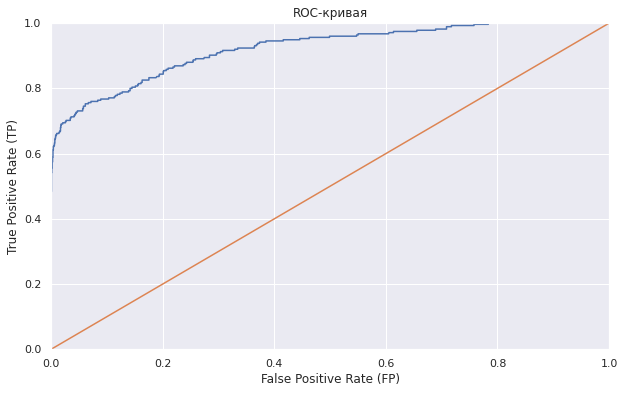

In [164]:
# ROC-кривая

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr)

# roc-кривая случайной модели
plt.plot([0, 1], [0, 1])

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate (FP)')
plt.ylabel('True Positive Rate (TP)')
plt.title('ROC-кривая')
plt.show()

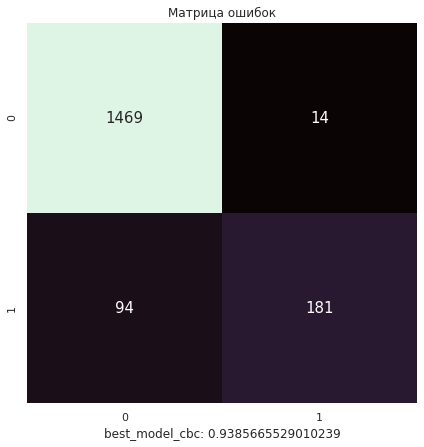

In [165]:
# матрица ошибок

labels = [0, 1]
plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_matrix(target_test, pred),
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt='1.0f',
            cbar=False,
            annot_kws={'size': 15},
            cmap='mako')
plt.title('Матрица ошибок', fontsize=12)
plt.xlabel(
    f'best_model_cbc: {accuracy_score(target_test, pred)}',
    fontsize=12)
plt.show()

In [166]:
#feature Importance
# определение важности признаков

feature_results = pd.DataFrame(
        {'feature': list(features_train.columns),
         'importance': model_cbc.best_estimator_._final_estimator.feature_importances_}
    ).sort_values('importance', ascending = False).reset_index(drop=True)

feature_results

feature  importance
0                   contract_duration_days   73.336361
1                            total_charges    5.938360
2                          number_services    4.159974
3                          monthly_charges    3.034298
4                              partner_yes    2.406560
5                       multiple_lines_yes    2.245922
6                            type_two_year    2.012868
7              payment_method_mailed_check    1.287736
8                            type_one_year    1.051249
9         multiple_lines_no_multiple_lines    0.771191
10                          dependents_yes    0.708285
11                       online_backup_yes    0.638405
12  payment_method_credit_card_(automatic)    0.438906
13                        tech_support_yes    0.359779
14                   device_protection_yes    0.353340
15                  paper_less_billing_yes    0.328287
16         payment_method_electronic_check    0.310960
17                        senior_citizen_1    0.281830
18                     online_security_yes    0.239213
19                        streaming_tv_yes    0.096476
20               online_backup_no_internet    0.000000
21           device_protection_no_internet    0.000000
22                tech_support_no_internet    0.000000
23                streaming_tv_no_internet    0.000000
24            streaming_movies_no_internet    0.000000
25                    streaming_movies_yes    0.000000
26             online_security_no_internet    0.000000

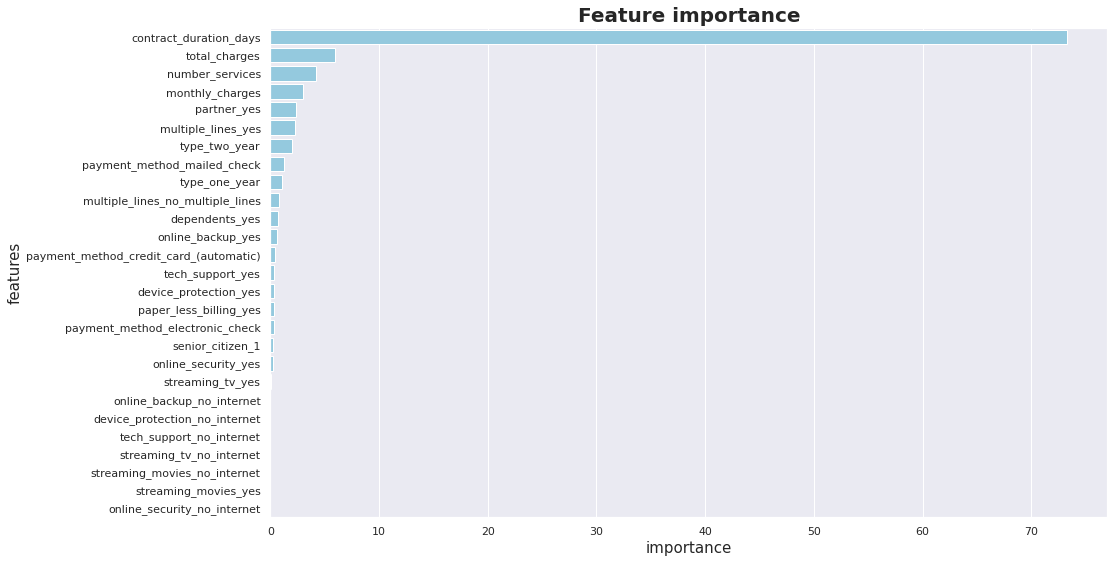

In [167]:
# важность признаков

plt.subplots(figsize=(15, 9))
sns.barplot(x = feature_results['importance'], 
            y = feature_results['feature'],
            data = feature_results,
            color = 'skyblue'
           )

plt.title('Feature importance', fontsize=20, weight = 'bold')
plt.xlabel('importance', fontsize=15)
plt.ylabel('features', fontsize=15)
plt.show()

По матрице корредяции phik получили данные, отсортированые по убыванию:
end_date – целевой признак, contract_duration_days, total_charges, contract_duration_days_num,  partner, monthly_charges, total_charges_num, payment_method, number_services, monthly_charges_num, multiple_lines, type,  оnline_backup, streaming_movies, senior_citizen, device_protection, paper_less_billing, streaming_tv, online_security,  internet_service, tech_support, dependents, gender. <br><br> Для обучения моделей были опробованы разные комбинции признаков и в результате лучшие показатели метрики получили при обучение со следующи списков признаков: end_date -целевой, contract_duration_days, total_charges, partner, monthly_charges, payment_method, number_services, multiple_lines, type, online_backup, streaming_movies, senior_citizen, device_protection, paper_less_billing, streaming_tv, online_security, tech_support, dependents.<br><br>Данные была разделена на тренировочную и тестовую выборкии в отношении 75/25. Кодирование и масштабирование признаков произвели с помощью OneHotEncoder и StandardScaler().так как при обучении была выбрана метрика качества ROC-AUC, которая нечувствительна к дисбалансу классов, дисбаланс оставлен, балансировку признака не производили.<br><br>
Для решения задачи классификации и предсказания факта оттока клиента были обучены 3 модели: LogisticRegression, RandomForestClassifier и CatBoostClassifier. Выбор модели и подбор гиперпараметров осуществлялся с помощью GridSearchCV с кросс-валидацией.<br> Лучший результат показала модель CatBoostClassifier с показателями: лучший набор параметров: cbc_best_params {'cbc__depth': 2, 'cbc__iterations': 96, 'c_rate': 1, 'cbc__verbose': 100}, лучший результат: 0.9053462408631043 ROC-auc на тренировочной и ROC-AUC: 0.9216992582602832, Accoracy CatBoostClassifier 0.9385665529010239 на тестовой выборках. Целью была метрика ROC-auc = 0,85 - показатель достигнут. <br>Матрица ошибок: значение TN - 1469 - модель хорошо предсказывает пользователей, которые не уйдут; значение TP - 181 - модель предсказывает пользователей, которые  уйдут; значение FP - 14 - модель предсказала пользователей, которые уйдут, что не уйдут; значение FN - 94 -модель предсказала пользователей, которые  не уйдут, что уйдут. <br>Разбивка на интервалы числовых признаков немного ухудшает метрику, но помогает в аналитике. Наиболее важными признаками Топ-5 в CatBoostClassifier оказались: 'contract_duration_days', 'total_charges', 'number_services', 'monthly_charges', 'partner_yes'.

## Отчет

   **<u>Целью проекта </u>** было создание модели для прогнозирования оттока клиентов и достижение минимального порога метрики AUC-ROC=0.85.<br> Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Перед нами задача бинарной классификации. <br>Цель проекта достигнута.<br> Все шаги плана выполнены.

**Загрузка и открытие файлов   с днными** <br> Исходные данные состояли из 4 таблиц: 
- contract_new.csv, — информация о договоре: размер данных: строк 7043, столбцов 8,  кoличество ячееек: 56344, тип данных float64(1), object(7), пропуски и дубликаты отсутствуют; 
    - Столбцы:
        - customerID - идентификатор клиента, тип object;
        - BeginDate - дата начала пользования услугами, дата заключения договора, тип object;
        - EndDate - дата окончания договора, тип object;
        - Type - тип оплаты: ежемесячный, годовой и т.д., тип object;
        - PaperlessBilling - электронный платежный документ, тип object;
        - PaymentMethod - способ оплаты, тип object;
        - MonthlyCharges - ежемесячные траты на услуги, ежемесячные платежи, тип float64;
        - TotalCharges - всего потрачено денег на услуги, всего начислений, тип object;

- personal_new.csv — персональные данные клиента: размер данных: строк 7043, столбцов 5,  кoличество ячееек: 35215, тип данных int(1), object(4), пропуски и дубликаты отсутствуют;
    - Столбцы:
        - customerID - идентификатор клиента, тип object;
        - gender - пол: мужины, женщины, тип object;
        - SeniorCitizen - наличие пенсионного статуса по возрасту, тип int (целочисленный);
        - Partner - наличие супруга(и), тип object;
        - Dependents - наличие иждивенцев, тип object;
          Все признаки категориальные.

- internet_new.csv — информация об интернет-услугах: размер данных: строк 5517, столбцов 8,  кoличество ячееек: 44136, тип данных оbject(8), пропуски и дубликаты отсутствуют;
    - Столбцы:
        - customerID - идентификатор клиента, тип object;
        - InternetService - интернет-сервис, подключение может быть двух типов: DSL (digital subscriber line) - цифровая абонентская линия или Fiber optic - оптоволоконный кабель; тип object;
        - OnlineSecurity - онлайн-безопасность, блокировка небезопасных сайтов; тип object;
        - OnlineBackup - облачное хранилище файлов для резервного копирования данных, тип object;
        - DeviceProtection - защита устройств, антивирус; тип object;
        - TechSupport - выделенная линия технической поддержки, тип object;
        - StreamingTV - стриминговое (потоковое) телевидение, тип object;
        - StreamingMovies - каталог фильмов, стриминговое (потоковое) воспроизведение фильмов, тип object;
          Все признаки категориальные.
- phone_new.csv — информация об услугах телефонии: размер данных: строк 6361, столбцов 2,  кoличество ячееек: 12722, тип данных оbject(2), пропуски и дубликаты отсутствуют. 
    - Столбцы:
        - customerID - идентификатор клиента, тип object;
        - MultipleLines - несколько линий, тип object;
          Признак категориальный.

Количество уникальных пользователей в данных  internet и phone <u>не совпадает </u>с количеством пользователей в данных contract и personal. Вероятно это говорит о том, что недостающие пользователи просто не пользуются итернет-услугами и услугами телефонии.
Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020. Дата заключения договора охватывает период с 01 октября 2013 по 01 февраля 2020 (дата выгрузки данных).

Предобработка данных:
   - данные с типом object привели к нижнему регистру, удалили пробелы в начале и в конце строки, пробелы внутри строки заменили на нижнее подчеркивание,
   - названия столбцов приведены к нижнему регистру,
   - тип данных BeginDate сменили на datetime,  тип данных TotalCharges сменить тип на float,
   - исходный столбец 'enddate' перезаписали как 'end_date_original' и добавили новый столбец EndDate с целочисленным значением "0" или "1" в зависимости от статуса договора, значение "no" в столбце 'end_date_original' заменили датой 01 февраля 2020 (дата выгрузки данных),
   - для моделей столбцы с датой не понадобились во избежание утечки данных, мы создадили дополнительный признак 'contract_duration_days' (количество дней контакта).
   - столбец EndDate - делаем целевым признаком, так как именно расторжение (прекращение) договора является признаком оттока клиента. Необходимо заменить данные столбца на "0" (если договор действующий) и на "1" (если договор расторгнут).

Сложности:
   - При попытке смены типа данных в contract['total_charges'] к типу float возникла ошибка, так как обнаружились значения " " (пусто). Всего 11 строк с пропущенным значением, датированы 01 февраля 2020 года (момент выгрузки данных), договора действующие, следовательно можно предположить, что общая сумма еще не сформирована, т.к. клиент пользовался услугами 1 день. Вероятно, можно заполнить эти пропуски значением столбца monthly_charges, либо 0. Заполнили значением столбца monthly_charges.

Полученный целевой признак:
    - столбуц ‘end_date’
    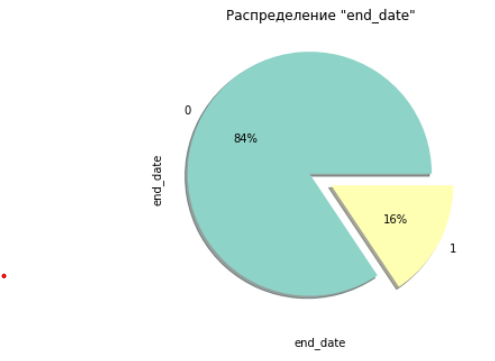
    - Присутствует дисбаланс. Количество действующих контрактов 84%, количество расторгнутых контрактов 16%.

**Объединение данных** <br> 
   - Данные из 4-х таблиц объединили <u>методом merge </u> - все имеющиеся столбцы объединили по customer_id для дальнейшего анализа их важности для машинного обучения.
   - Получили таблицу с размером данных: (7043, 20) и кoличеством ячееек: 140860. Типы данных: float64(2), int64(2), object(16).
   - Из-за разного количества уникальных пользователей в данных contracr, personal и internet, phone в данных появились пропуски у клиентов, которые не ползовались интернет-услугами либо услугами телефонии. Данные пропуски заменили заглушками, соответственно, no_internet и no_phone.
   - Полученные в результате преобразования дубликаты строк удалили.

**Новые признаки**<br>
   - Все числовые столбцы разбили на интервалы и создали новые признаки, присвоив интервалам номера: contract_duration_days_num, total_charges_num, monthly_charges_num
   - Добавлен столбце с количеством интернет-услуг по каждому пользователю number_services.<br>
   
   К сожалению, разбивка на интервалы не улучшила метрики моделей, но помогла для анализа и более наглядной визуализации признаков. Для обучения модели исользовали исходные числовые столбцы.

**Анализ признаков**<br>
По матрице корредяции phik получили данные, отсортированые по убыванию:
   - end_date                      1.000000 – целевой признак, 
   - contract_duration_days        0.374361,
   - total_charges                 0.304151,
   - contract_duration_days_num    0.265742,
   - partner                       0.226776,
   - monthly_charges               0.226314,
   - total_charges_num             0.223543,
   - payment_method                0.214624,
   - number_services               0.182493,
   - monthly_charges_num           0.167960,
   - multiple_lines                0.105152,
   - type                          0.094073,
   - оnline_backup                 0.089683,
   - streaming_movies              0.086546,
   - senior_citizen                0.085995,
   - device_protection             0.085582,
   - paper_less_billing            0.083159,
   - streaming_tv                  0.078503,
   - online_security               0.058587,
   - internet_service              0.056527,
   - tech_support                  0.051437,
   - dependents                    0.046841,
   - gender                        0.009029.
 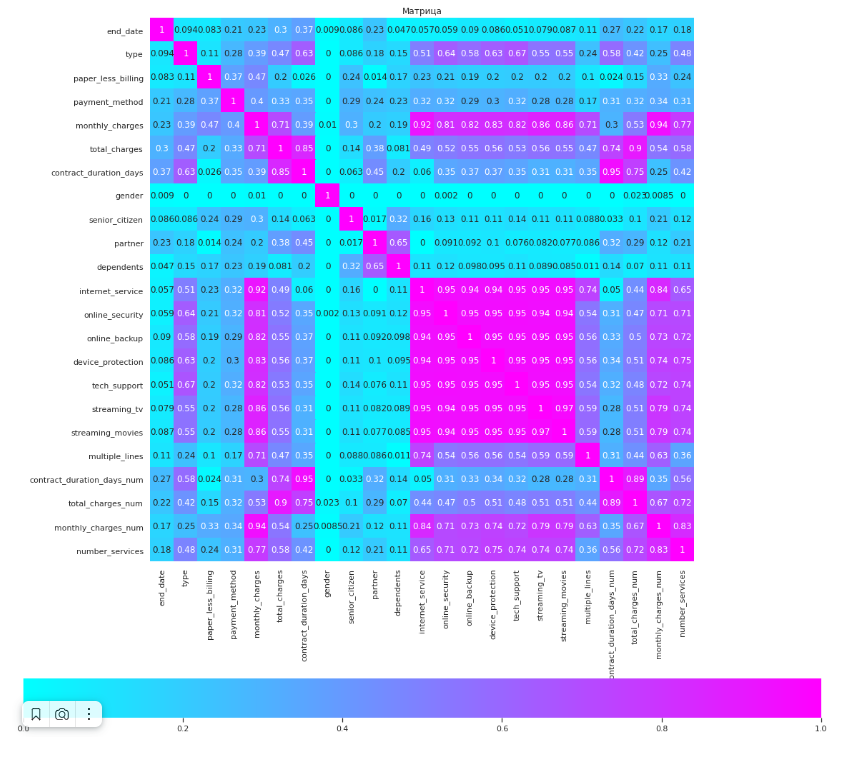
   - Самая низкая корреляция у признака 'gender', удалим его
   - Мы видим высокую корреляцию между 
      - contract_duration_days и contract_duration_days_num
      - total_charges и total_charges_num 
      - monthly_charges и monthly_charges_num - 
      это одни и те же данные, просто в _num_ они разбиты на интервалы. И так как в рейтинге исходные непрерывные данные выше, то в рабочей таблице data оставимих, а интервалы используем для визуализации.

**Рабочие данные для машинного обучения:**<br>
Таблица data размером (7031, 18). Кoличество ячееек: 126558. 5 количественных столбца и 13 категориальных.<br>
Пропуков нет, дубликаты удадены.<br>
По матрице корредяции phik получили данные, отсортированые по убыванию: end_date – целевой признак, contract_duration_days, total_charges, contract_duration_days_num, partner, monthly_charges, total_charges_num, payment_method, number_services, monthly_charges_num, multiple_lines, type, оnline_backup, streaming_movies, senior_citizen, device_protection, paper_less_billing, streaming_tv, online_security, internet_service, tech_support, dependents, gender.
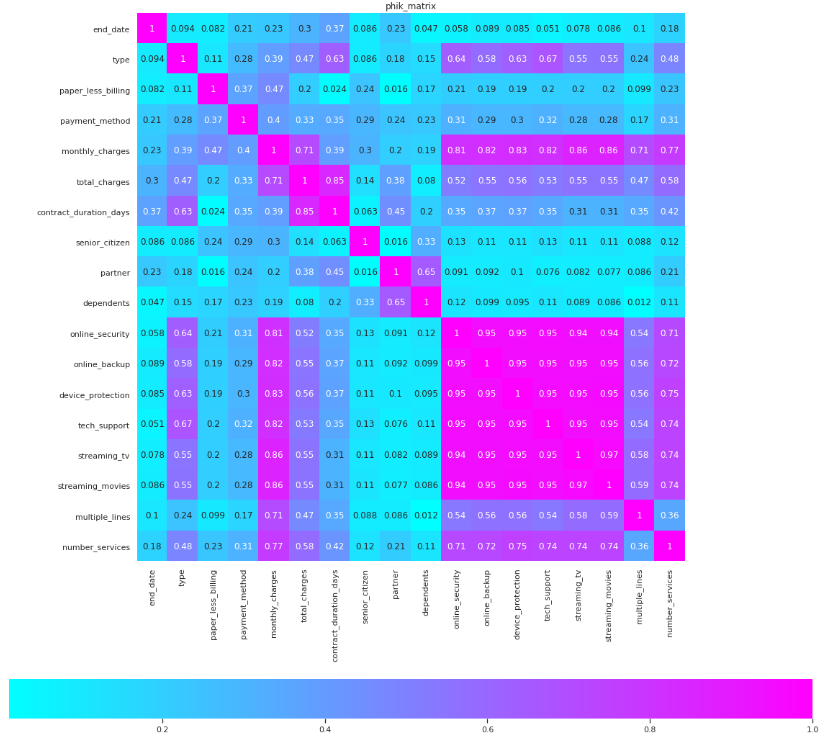

**Наибольший процент оттока клиентов по признакам:**
   - признак gendeer (пол) - практически нет различия по процентам оттока, поэтому этот признак удален,
   - признак partner (наличие супруга(и)) - наибольший процент оттока клиентов со статусом ‘yes,
   - признак payment_method (способ оплаты) -  наибольший процент оттока клиентов со способом оплаты bank_transfer_(automatic) и credit_card_(automatic). Оба способа оплаты автоматические,
   - признак 'multiple_lines' (возможно ли подключение телефонного аппарата к нескольким линиям одновременно) - наибольший процент оттока у клиента со статусом yes,
   - признак 'type' (тип оплаты: ежемесячный, годовой и т.д) – с типом оплаты 1 и 2 года (годовой, двухгодовой),
   - признак 'senior_citizen' (наличие пенсионного статуса по возрасту) – клиенты со статусом пенсионера,
   - признак 'paper_less_billing' (электронный платежный документ) – клиенты со статусом yes (подключен),
   - признак 'dependents' (наличие иждивенцев) – клиенты со статусом yes, хотя разница с no уже не очень существенная,
   - признак 'internet_service' (интернет-сервис, подключение может быть двух типов: DSL (digital subscriber line) - цифровая абонентская линия или Fiber optic - оптоволоконный кабель) – отток у клиентов с fiber_optic,
   - признак online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies – наибольший процент у клиентов с подключенными услугами.<br>
   Для интервальных столбцов наибольший отткок:<br>
   - contract_duration_days с продолжительностью контракта 1000 дней, что выше среднего значения показателя contract_duration_days (среднее значение в столбце количества дней составляет 942.806612, медиана 822). Реже всего разрываются долгосрочные контракты.
   - 'number_services' (количество подключенных услуг клиента) – у клиентов с 3-4 подключенными услугами. Большинство подключенных услуг влияют на ежемесячные траты и существенно их увеличивают, поэтому повышается риск оттока клиентов.
   - total_charges (видно на гистограмме интервалов) наибольший отток у клиентов с суммой расходов в районе 2000, наибольшие проценты относятся к интервалам 6 и 7, что соответствует суммам 1699.0 - 2862.32 и 2862.32 <- 4690.29.
   - monthly_charges_num (ежемесячные платежи) отток клиентов увеличивпется с увеличением суммы ежемесячных трат на услуги. Набольший процент в 7 и 8 диапазонах, что соответствует суммам 86.5 - 99.1 и 99.1 - 118.75

**Обучение моделей**<br><br> Были опробованы разные комбинции признаков и в результате лучшие показатели метрики получили при обучение со следующи списков признаков (рабочие данные data): end_date -целевой, contract_duration_days, total_charges, partner, monthly_charges, payment_method, number_services, multiple_lines, type, online_backup, streaming_movies, senior_citizen, device_protection, paper_less_billing, streaming_tv, online_security, tech_support, dependents.<br><br>

**Разделение на выборки** Данные была разделена на тренировочную и тестовую выборкии в отношении 75/25. <br><br>**Кодирование и масштабирование** признаков произвели с помощью OneHotEncoder и StandardScaler().<br><br>Так как при обучении была выбрана метрика качества ROC-AUC, которая нечувствительна к дисбалансу классов, дисбаланс оставлен, **балансировку признака не производили**.
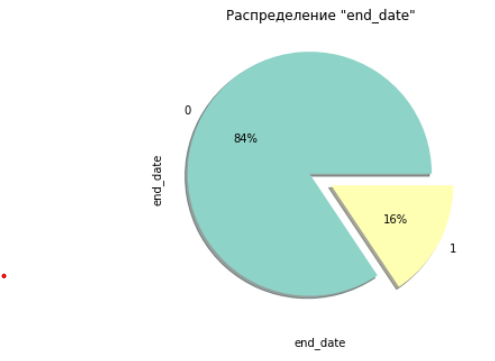

Для решения задачи классификации и предсказания факта оттока клиента были обучены 3 модели: LogisticRegression, RandomForestClassifier и CatBoostClassifier. Выбор модели и подбор гиперпараметров осуществлялся с помощью GridSearchCV с кросс-валидацией (cv=5).<br>

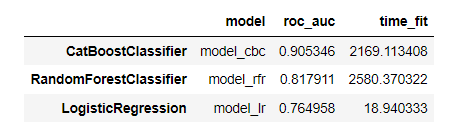

**Лучший результат показала модель CatBoostClassifier с показателями:** 
   - лучший набор параметров: 
      - cbc_best_params {'cbc__depth': 2, 'cbc__iterations': 96, 'c_rate': 1, 'cbc__verbose': 100}, random_state=140823 
   - лучший результат: 
      - 0.9053462408631043 ROC-auc на тренировочной 
      - ROC-AUC: 0.9216992582602832, Accoracy CatBoostClassifier 0.9385665529010239 на тестовой выборках. 

Целью была метрика ROC-auc = 0,85 - показатель достигнут.
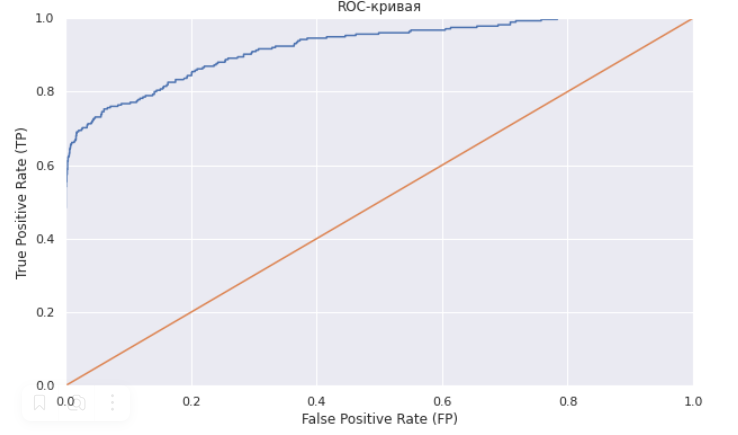

Матрица ошибок: 
 

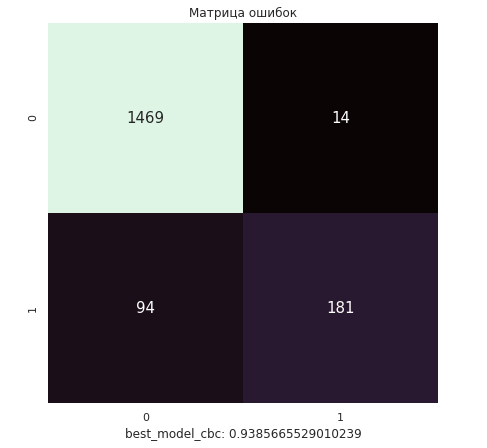

- значение TN - 1469 - модель хорошо предсказывает пользователей, которые не уйдут; 
- значение TP - 181 - модель предсказывает пользователей, которые уйдут; 
- значение FP - 14 - модель предсказала пользователей, которые уйдут, что не уйдут; 
- значение FN - 94 -модель предсказала пользователей, которые не уйдут, что уйдут.

Разбивка на интервалы числовых признаков немного ухудшает метрику, но помогает в аналитике.<br><br>
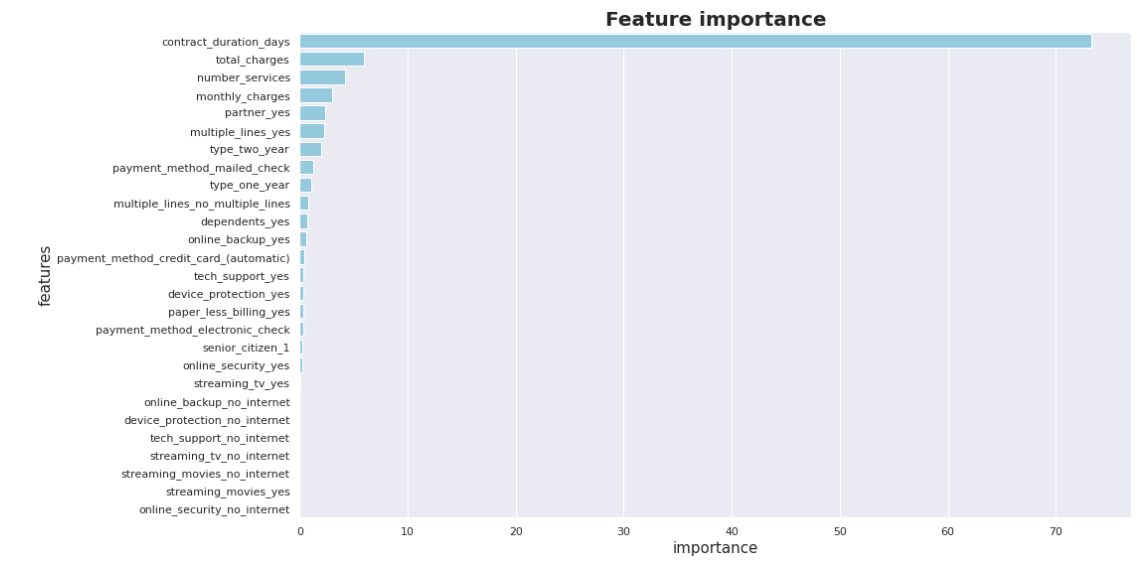

 Наиболее важными признаками Топ-5 в CatBoostClassifier оказались: 
   - 'contract_duration_days', 
   - 'total_charges', 
   - 'number_services', 
   - 'monthly_charges', 
   - 'partner_yes'. 

**Итог**<br>Выбор модели и подбор гиперпараметров осуществлялся с помощью GridSearchCV с кросс-валидацией (cv=5).<br><br>
Лучший результат показала модель CatBoostClassifier с показателями:

   - лучший набор параметров:
      - cbc_best_params {'cbc__depth': 2, 'cbc__iterations': 96, 'c_rate': 1, 'cbc__verbose': 100}, RANDOM_STATE=140823.
   - лучший результат:
      - 0.9053462408631043 ROC-auc на тренировочной
      - ROC-AUC: 0.9216992582602832, Accoracy CatBoostClassifier 0.9385665529010239 на тестовой выборках <br><br> 
с набором признаков: end_date -целевой, contract_duration_days, total_charges, partner, monthly_charges, payment_method, number_services, multiple_lines, type, online_backup, streaming_movies, senior_citizen, device_protection, paper_less_billing, streaming_tv, online_security, tech_support, dependents.